# 📦 Setup and Imports

In [10]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data_io import load_excel_data, clean_observations, get_annual_summary

# set some plotting defaults
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [11]:
# load the data
data = load_excel_data('../data/raw/Observations 2012-2025.xlsx')
df_obs = data['observations']
df_species = data['species']
df_gps = data['gps']

Loading data from ../data/raw/Observations 2012-2025.xlsx
Loaded 86 species
Loaded 651 GPS points
Converting count columns to numeric
Loaded 114497 observation records


In [12]:
# ============================================================
# 1. LOAD & PREPARE DATA
# ============================================================

# Import additional libraries needed for analysis
from scipy import stats
from scipy.stats import shapiro
import statsmodels.api as sm

# Clean the observations data
df_clean = clean_observations(df_obs)

# Filter data for years 2015-2024
df_filtered = df_clean[(df_clean['year'] >= 2015) & (df_clean['year'] <= 2024)].copy()

print(f"Filtered data for years 2015-2024: {len(df_filtered)} observations")
print(f"Year range: {df_filtered['year'].min()} - {df_filtered['year'].max()}")
print(f"Unique species: {df_filtered['species_name'].nunique()}")
print(f"Unique years: {sorted(df_filtered['year'].unique())}")


Data Cleaning
Starting with 114497 records
⚠ Found 5 negative wind values - setting to NaN
Removed 4 records with zero/negative counts
Final dataset: 114493 records
  Years: 2014 - 2025
  Unique species: 102
  Unique transects: 72
  Unique observers: 42
Filtered data for years 2015-2024: 99344 observations
Year range: 2015 - 2024
Unique species: 98
Unique years: [np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]


In [13]:
# ============================================================
# 2. COMPUTE DIVERSITY METRICS PER YEAR
# ============================================================

def calculate_shannon_diversity(df_year):
    """
    Calculate Shannon diversity index for a given year's data.
    H' = -Σ(p_i * ln(p_i)), where p_i = proportion of individuals per species
    """
    # Get total count per species for this year
    species_counts = df_year.groupby('species_name')['individual_count'].sum()
    
    # Calculate total individuals
    total_individuals = species_counts.sum()
    
    if total_individuals == 0:
        return np.nan
    
    # Calculate proportions
    proportions = species_counts / total_individuals
    
    # Remove zero proportions (they don't contribute to Shannon)
    proportions = proportions[proportions > 0]
    
    # Calculate Shannon index
    shannon = -np.sum(proportions * np.log(proportions))
    
    return shannon

# Compute metrics for each year
annual_metrics = []

for year in sorted(df_filtered['year'].unique()):
    df_year = df_filtered[df_filtered['year'] == year]
    
    # Species richness (number of unique species)
    richness = df_year['species_name'].nunique()
    
    # Shannon diversity
    shannon = calculate_shannon_diversity(df_year)
    
    # Number of records
    n_records = len(df_year)
    
    annual_metrics.append({
        'year': year,
        'richness': richness,
        'shannon': shannon,
        'n_records': n_records
    })

# Create dataframe
df_annual = pd.DataFrame(annual_metrics)
df_annual = df_annual.sort_values('year').reset_index(drop=True)

print("Annual Diversity Metrics (2015-2024):")
print(df_annual.to_string(index=False))


Annual Diversity Metrics (2015-2024):
 year  richness  shannon  n_records
 2015        70 3.062091       8162
 2016        77 3.053396      11010
 2017        71 3.020512       9228
 2018        73 2.999394       9733
 2019        70 3.014705       9572
 2020        68 3.043480       9956
 2021        69 3.045896      10604
 2022        68 3.036786      10804
 2023        67 3.057674      10224
 2024        70 3.043292      10051


In [14]:
# ============================================================
# 3. BOOTSTRAP CONFIDENCE INTERVALS (1000 ITERATIONS)
# ============================================================


np.random.seed(42)  # For reproducibility
n_bootstrap = 1000

bootstrap_results = []

print("Computing bootstrap confidence intervals (1000 iterations)...")

for year in sorted(df_filtered['year'].unique()):
    df_year = df_filtered[df_filtered['year'] == year]
    n_obs = len(df_year)
    
    # Preallocate lists for efficiency
    richness_bootstrap = np.empty(n_bootstrap)
    shannon_bootstrap = np.empty(n_bootstrap)
    shannon_bootstrap[:] = np.nan  # Initialize with NaN

    # Bootstrap iterations
    for i in range(n_bootstrap):
        # Resample with replacement
        df_boot = df_year.sample(n=n_obs, replace=True)
        
        # Richness: number of unique species
        richness_bootstrap[i] = df_boot['species_name'].nunique()
        
        # Shannon diversity (if defined)
        shannon_val = calculate_shannon_diversity(df_boot)
        if not np.isnan(shannon_val):
            shannon_bootstrap[i] = shannon_val
    
    # ===== Compute Richness Confidence Intervals =====
    richness_ci_lower, richness_ci_upper = np.percentile(richness_bootstrap, [2.5, 97.5])
    
    # ===== Compute Shannon Confidence Intervals =====
    valid_shannon = shannon_bootstrap[~np.isnan(shannon_bootstrap)]
    if valid_shannon.size > 0:
        shannon_ci_lower, shannon_ci_upper = np.percentile(valid_shannon, [2.5, 97.5])
    else:
        shannon_ci_lower, shannon_ci_upper = np.nan, np.nan

    bootstrap_results.append({
        'year': year,
        'richness_ci_lower': richness_ci_lower,
        'richness_ci_upper': richness_ci_upper,
        'shannon_ci_lower': shannon_ci_lower,
        'shannon_ci_upper': shannon_ci_upper
    })
    
    print(f"  Year {year}: completed")

# Merge bootstrap results with annual metrics
df_bootstrap = pd.DataFrame(bootstrap_results)
df_annual = df_annual.merge(df_bootstrap, on='year', how='left')

print("\nBootstrap confidence intervals added:")
print(df_annual[['year', 'richness', 'richness_ci_lower', 'richness_ci_upper', 
                 'shannon', 'shannon_ci_lower', 'shannon_ci_upper']].to_string(index=False))

Computing bootstrap confidence intervals (1000 iterations)...
  Year 2015: completed
  Year 2016: completed
  Year 2017: completed
  Year 2018: completed
  Year 2019: completed
  Year 2020: completed
  Year 2021: completed
  Year 2022: completed
  Year 2023: completed
  Year 2024: completed

Bootstrap confidence intervals added:
 year  richness  richness_ci_lower  richness_ci_upper  shannon  shannon_ci_lower  shannon_ci_upper
 2015        70               62.0               69.0 3.062091          3.001718          3.097015
 2016        77               68.0               75.0 3.053396          3.011104          3.082109
 2017        71               63.0               70.0 3.020512          2.972865          3.055492
 2018        73               65.0               72.0 2.999394          2.955989          3.029720
 2019        70               63.0               69.0 3.014705          2.968303          3.043891
 2020        68               62.0               68.0 3.043480          2.9

MODEL ASSUMPTION CHECKS

Species Richness Model:
  Shapiro-Wilk test statistic: 0.9128
  P-value (normality): 0.3006
  Interpretation: Residuals appear normal

Shannon Diversity Model:
  Shapiro-Wilk test statistic: 0.9574
  P-value (normality): 0.7555
  Interpretation: Residuals appear normal


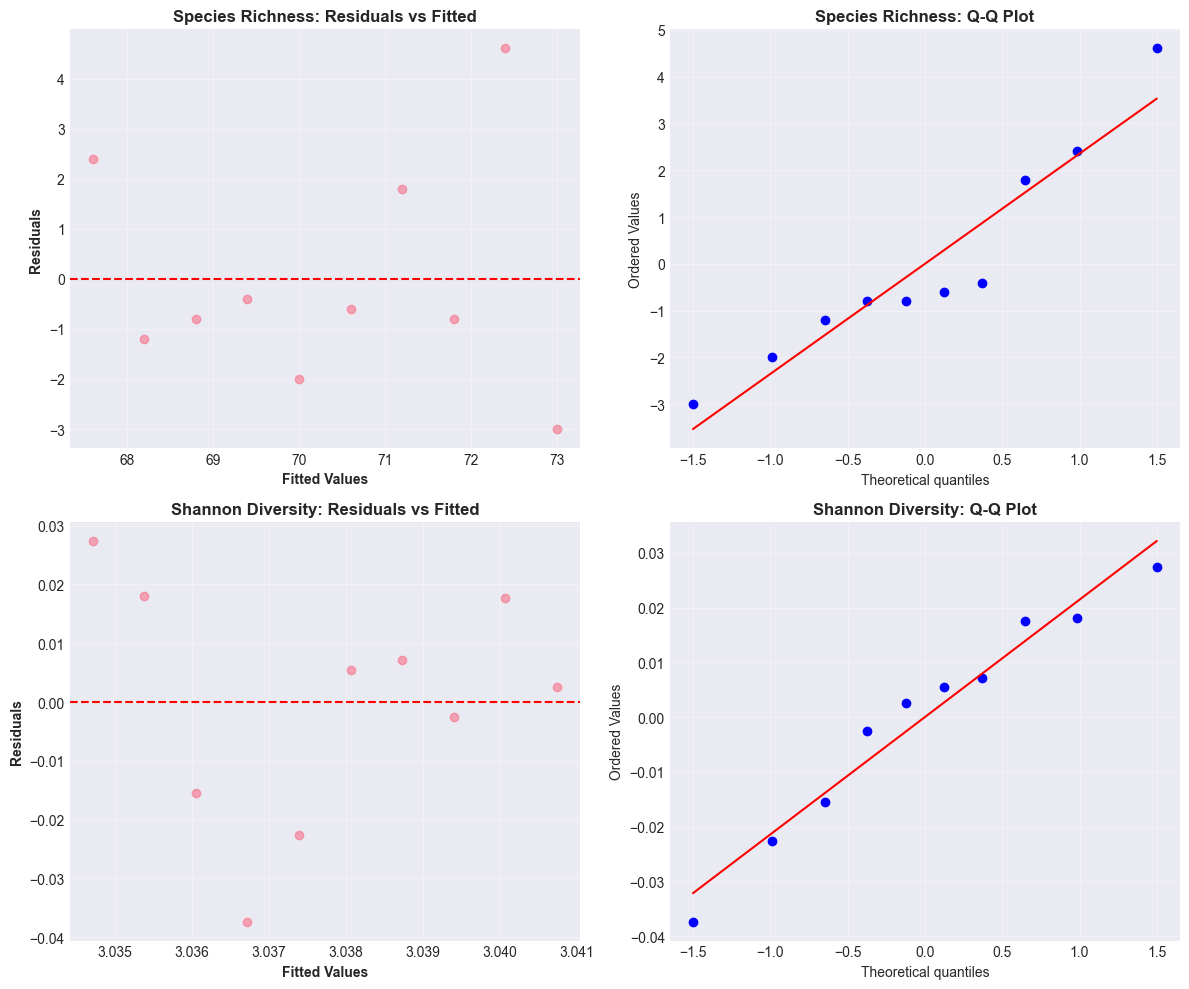


Saved diagnostic plots: ../figures/indicator_model_diagnostics.png


In [16]:
# ============================================================
# 5. CHECK MODEL ASSUMPTIONS
# ============================================================

# Shapiro-Wilk test for normality of residuals
print("=" * 60)
print("MODEL ASSUMPTION CHECKS")
print("=" * 60)

# Richness residuals
stat_richness, p_richness = shapiro(model_richness.resid)
print("\nSpecies Richness Model:")
print(f"  Shapiro-Wilk test statistic: {stat_richness:.4f}")
print(f"  P-value (normality): {p_richness:.4f}")
print(f"  Interpretation: {'Residuals appear normal' if p_richness > 0.05 else 'Residuals may not be normal'}")

# Shannon residuals
stat_shannon, p_shannon = shapiro(model_shannon.resid)
print("\nShannon Diversity Model:")
print(f"  Shapiro-Wilk test statistic: {stat_shannon:.4f}")
print(f"  P-value (normality): {p_shannon:.4f}")
print(f"  Interpretation: {'Residuals appear normal' if p_shannon > 0.05 else 'Residuals may not be normal'}")

# Create diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Richness: Residuals vs Fitted
axes[0, 0].scatter(model_richness.fittedvalues, model_richness.resid, alpha=0.6)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Fitted Values', fontweight='bold')
axes[0, 0].set_ylabel('Residuals', fontweight='bold')
axes[0, 0].set_title('Species Richness: Residuals vs Fitted', fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Richness: Q-Q plot
stats.probplot(model_richness.resid, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Species Richness: Q-Q Plot', fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Shannon: Residuals vs Fitted
axes[1, 0].scatter(model_shannon.fittedvalues, model_shannon.resid, alpha=0.6)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Fitted Values', fontweight='bold')
axes[1, 0].set_ylabel('Residuals', fontweight='bold')
axes[1, 0].set_title('Shannon Diversity: Residuals vs Fitted', fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Shannon: Q-Q plot
stats.probplot(model_shannon.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Shannon Diversity: Q-Q Plot', fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/indicator_model_diagnostics.png', dpi=300, bbox_inches='tight')
plt.show()
print("\nSaved diagnostic plots: ../figures/indicator_model_diagnostics.png")


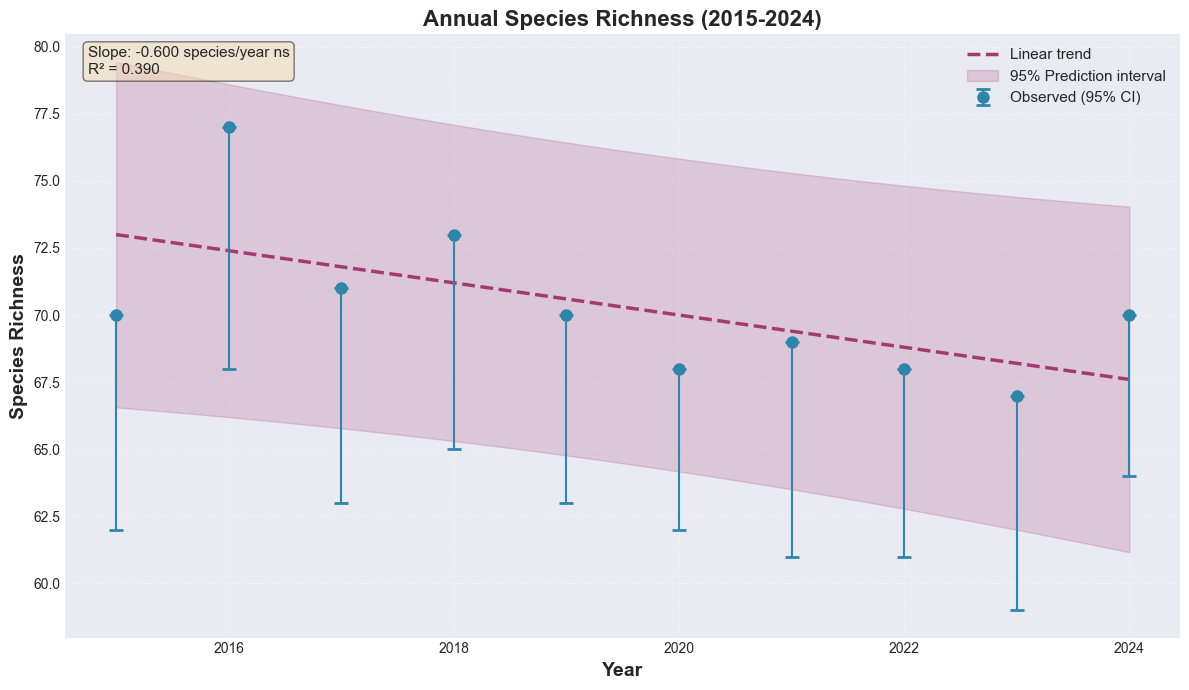

Saved: ../figures/indicator_species_richness.png


In [17]:
# ============================================================
# 6. CREATE PUBLICATION-QUALITY PLOTS
# ============================================================

# Generate prediction intervals for trend lines
# Create a fine grid of years for smooth trend lines
years_smooth = np.linspace(df_annual['year'].min(), df_annual['year'].max(), 100)
years_smooth_centered = years_smooth - year_mean

# Get predictions for trend lines
X_smooth_richness = sm.add_constant(years_smooth_centered)
pred_richness = model_richness.get_prediction(X_smooth_richness)
pred_richness_frame = pred_richness.summary_frame(alpha=0.05)

X_smooth_shannon = sm.add_constant(years_smooth_centered)
pred_shannon = model_shannon.get_prediction(X_smooth_shannon)
pred_shannon_frame = pred_shannon.summary_frame(alpha=0.05)

# ============================================================
# Plot 1: Annual Species Richness
# ============================================================
fig, ax = plt.subplots(figsize=(12, 7))

# Plot observed data with error bars
yerr_lower = (df_annual['richness'] - df_annual['richness_ci_lower']).clip(lower=0)
yerr_upper = (df_annual['richness_ci_upper'] - df_annual['richness']).clip(lower=0)

ax.errorbar(
    df_annual['year'], df_annual['richness'],
    yerr=[yerr_lower, yerr_upper],
    fmt='o', color='#2E86AB', markersize=8, capsize=5, capthick=2,
    label='Observed (95% CI)', zorder=3
)

# Plot trend line
ax.plot(years_smooth, pred_richness_frame['mean'], 
        '--', color='#A23B72', linewidth=2.5, label='Linear trend', zorder=2)

# Plot 95% prediction interval
ax.fill_between(years_smooth, 
                pred_richness_frame['obs_ci_lower'], 
                pred_richness_frame['obs_ci_upper'],
                alpha=0.2, color='#A23B72', label='95% Prediction interval', zorder=1)

ax.set_xlabel('Year', fontweight='bold', fontsize=14)
ax.set_ylabel('Species Richness', fontweight='bold', fontsize=14)
ax.set_title('Annual Species Richness (2015-2024)', fontweight='bold', fontsize=16)
ax.grid(alpha=0.3, linestyle='--')
ax.legend(loc='best', fontsize=11)

# Add slope and significance annotation
slope = model_richness.params['year_centered']
pval = model_richness.pvalues['year_centered']
significance = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else 'ns'
ax.text(0.02, 0.98, f'Slope: {slope:.3f} species/year {significance}\nR² = {model_richness.rsquared:.3f}',
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../figures/indicator_species_richness.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: ../figures/indicator_species_richness.png")


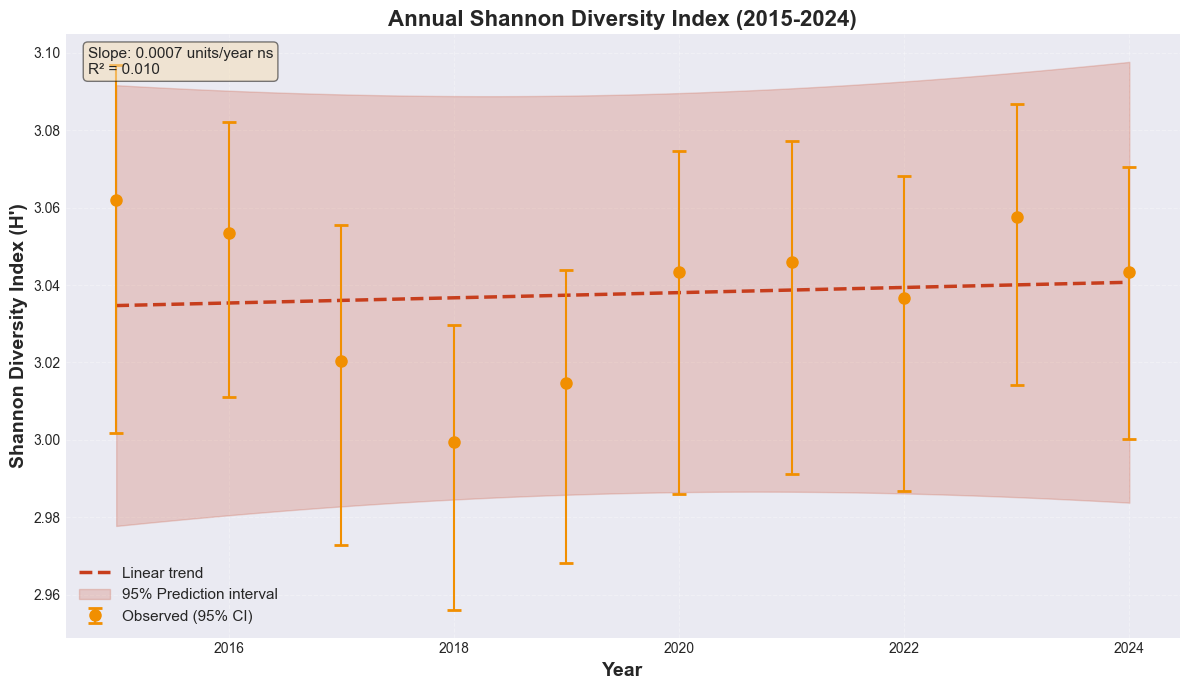

Saved: ../figures/indicator_shannon_diversity.png


In [18]:
# ============================================================
# Plot 2: Annual Shannon Diversity
# ============================================================
fig, ax = plt.subplots(figsize=(12, 7))

# Plot observed data with error bars
ax.errorbar(df_annual['year'], df_annual['shannon'], 
            yerr=[df_annual['shannon'] - df_annual['shannon_ci_lower'],
                  df_annual['shannon_ci_upper'] - df_annual['shannon']],
            fmt='o', color='#F18F01', markersize=8, capsize=5, capthick=2,
            label='Observed (95% CI)', zorder=3)

# Plot trend line
ax.plot(years_smooth, pred_shannon_frame['mean'], 
        '--', color='#C73E1D', linewidth=2.5, label='Linear trend', zorder=2)

# Plot 95% prediction interval
ax.fill_between(years_smooth, 
                pred_shannon_frame['obs_ci_lower'], 
                pred_shannon_frame['obs_ci_upper'],
                alpha=0.2, color='#C73E1D', label='95% Prediction interval', zorder=1)

ax.set_xlabel('Year', fontweight='bold', fontsize=14)
ax.set_ylabel('Shannon Diversity Index (H\')', fontweight='bold', fontsize=14)
ax.set_title('Annual Shannon Diversity Index (2015-2024)', fontweight='bold', fontsize=16)
ax.grid(alpha=0.3, linestyle='--')
ax.legend(loc='best', fontsize=11)

# Add slope and significance annotation
slope = model_shannon.params['year_centered']
pval = model_shannon.pvalues['year_centered']
significance = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else 'ns'
ax.text(0.02, 0.98, f'Slope: {slope:.4f} units/year {significance}\nR² = {model_shannon.rsquared:.3f}',
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../figures/indicator_shannon_diversity.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: ../figures/indicator_shannon_diversity.png")


In [16]:
"""
Person B - Abundance Metrics Analysis (Self-Contained Version)
Birds Biodiversity Project - Section 2: Multi-Year Indicator Trends

Indicators analyzed:
1. Total Abundance - Raw population metric across all species
2. Mean Abundance per Point - Effort-standardized abundance metric

"""

# ============================================================================
# STANDARD IMPORTS
# ============================================================================
import sys
sys.path.append('../src')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import linregress
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("✓ Standard imports successful")

from data_io import load_excel_data, clean_observations, get_annual_summary
# ============================================================================
# INDICATOR COMPUTATION FUNCTIONS
# ============================================================================

def compute_total_abundance(df):
    """
    Compute total abundance (sum of all individual counts).
    """
    return df['individual_count'].sum()

def compute_mean_abundance_per_point(df):
    """
    Compute mean abundance per observation point.
    Standardizes for sampling effort by dividing total abundance
    by the number of unique observation points visited.
    """
    # Count unique observation points
    n_points = df[['transect_name', 'point_number']].drop_duplicates().shape[0]
    
    # Total abundance
    total_abundance = df['individual_count'].sum()
    
    # Mean per point
    if n_points > 0:
        return total_abundance / n_points
    else:
        return 0

print("✓ Indicator functions defined")

# ============================================================================
# STATISTICAL UTILITIES
# ============================================================================

def bootstrap_ci(data, statistic_func, n_boot=1000, confidence_level=0.95):
    """
    Compute bootstrap confidence interval for a statistic.
    
    Parameters
    ----------
    data : pd.DataFrame
        Data to bootstrap
    statistic_func : callable
        Function that computes the statistic from data
    n_boot : int
        Number of bootstrap iterations
    confidence_level : float
        Confidence level (e.g., 0.95 for 95% CI)
        
    Returns
    -------
    dict
        Dictionary with 'estimate', 'lower', 'upper', 'stderr'
    """
    # Original estimate
    estimate = statistic_func(data)
    
    # Bootstrap resampling
    boot_stats = []
    n = len(data)
    
    for _ in range(n_boot):
        # Resample with replacement
        sample = data.sample(n=n, replace=True)
        boot_stats.append(statistic_func(sample))
    
    boot_stats = np.array(boot_stats)
    
    # Compute confidence interval
    alpha = 1 - confidence_level
    lower = np.percentile(boot_stats, 100 * alpha / 2)
    upper = np.percentile(boot_stats, 100 * (1 - alpha / 2))
    stderr = np.std(boot_stats)
    
    return {
        'estimate': estimate,
        'lower': lower,
        'upper': upper,
        'stderr': stderr
    }

def fit_linear_trend(x, y):
    """
    Fit linear trend model and return comprehensive results.
    
    Parameters
    ----------
    x : array-like
        Independent variable (e.g., years)
    y : array-like
        Dependent variable (e.g., indicator values)
        
    Returns
    -------
    dict
        Model results including slope, intercept, R², p-value, fitted values, residuals
    """
    # Fit linear model
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    # Predict values
    y_pred = slope * x + intercept
    residuals = y - y_pred
    
    # Compute 95% CI for slope
    n = len(x)
    t_val = stats.t.ppf(0.975, n - 2)  # 95% two-tailed
    slope_ci = (slope - t_val * std_err, slope + t_val * std_err)
    
    return {
        'slope': slope,
        'intercept': intercept,
        'r_squared': r_value**2,
        'p_value': p_value,
        'std_err': std_err,
        'slope_ci': slope_ci,
        'residuals': residuals,
        'fitted': y_pred
    }

def check_assumptions(residuals, fitted):
    """
    Check linear regression assumptions.
    
    Returns diagnostic statistics for:
    - Normality (Shapiro-Wilk test)
    - Homoscedasticity (correlation between |residuals| and fitted)
    - Independence (Durbin-Watson statistic)
    """
    # Normality
    shapiro_stat, shapiro_p = stats.shapiro(residuals)
    
    # Homoscedasticity
    abs_resid = np.abs(residuals)
    het_corr, het_p = stats.pearsonr(fitted, abs_resid)
    
    # Autocorrelation (Durbin-Watson)
    dw = np.sum(np.diff(residuals)**2) / np.sum(residuals**2)
    
    return {
        'normality': {'statistic': shapiro_stat, 'p_value': shapiro_p, 'pass': shapiro_p > 0.05},
        'homoscedasticity': {'correlation': het_corr, 'p_value': het_p, 'pass': het_p > 0.05},
        'independence': {'durbin_watson': dw, 'pass': 1.5 < dw < 2.5}
    }

print("✓ Statistical utilities defined")

# ============================================================================
# PLOTTING UTILITIES
# ============================================================================

def plot_temporal_trend(x_data, y_data, ci_lower, ci_upper, y_trend,
                       xlabel, ylabel, title, filename, color='steelblue',
                       trend_info=None):
    """
    Create publication-quality temporal trend plot.
    
    Parameters
    ----------
    x_data : array-like
        X-axis values (years)
    y_data : array-like
        Y-axis values (indicator estimates)
    ci_lower, ci_upper : array-like
        Confidence interval bounds
    y_trend : array-like
        Fitted trend line values
    xlabel, ylabel, title : str
        Axis labels and title
    filename : str
        Path to save figure
    color : str
        Color for data points and CI
    trend_info : dict, optional
        Dictionary with slope, r_squared, p_value for text box
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot data and CI
    ax.plot(x_data, y_data, 'o-', linewidth=2.5, markersize=10, 
            label='Observed', color=color, markeredgecolor='black', markeredgewidth=1)
    ax.fill_between(x_data, ci_lower, ci_upper, alpha=0.25, color=color, 
                     label='95% CI (Bootstrap)')
    
    # Plot trend line
    ax.plot(x_data, y_trend, '--', linewidth=2.5, color='red', label='Linear Trend')
    
    # Labels
    ax.set_xlabel(xlabel, fontsize=13, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=13, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Add trend info box if provided
    if trend_info:
        textstr = f'Slope: {trend_info["slope"]:+.4g}\n'
        textstr += f'R² = {trend_info["r_squared"]:.3f}\n'
        textstr += f'p = {trend_info["p_value"]:.4f}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
                verticalalignment='top', bbox=props)
    
    ax.legend(frameon=True, loc='upper right', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(x_data.min() - 0.5, x_data.max() + 0.5)
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✓ Figure saved to {filename}")
    plt.show()

print("✓ Plotting utilities defined")

print("\n" + "="*60)
print("ALL FUNCTIONS LOADED SUCCESSFULLY")
print("="*60)

✓ Standard imports successful
✓ Indicator functions defined
✓ Statistical utilities defined
✓ Plotting utilities defined

ALL FUNCTIONS LOADED SUCCESSFULLY


In [17]:
"""
Load data and filter to complete years (2015-2024)
Excludes partial years 2014 and 2025
"""

print("=" * 60)
print("LOADING DATA")
print("=" * 60)

# Load raw data
data = load_excel_data('../data/raw/Observations 2012-2025.xlsx')
df_raw = data['observations']

print(f"\nRaw data loaded: {len(df_raw)} observations")

# Clean data
df = clean_observations(df_raw)

print(f"After cleaning: {len(df)} observations")

# Filter to complete years only (2015-2024)
df_complete = df[df['year'].between(2015, 2024)].copy()

print(f"After filtering to 2015-2024: {len(df_complete)} observations")
print(f"Years included: {sorted(df_complete['year'].unique())}")

# Verify data quality
print("\n" + "=" * 60)
print("DATA QUALITY CHECKS")
print("=" * 60)
print(f"Unique species: {df_complete['species_name'].nunique()}")
print(f"Unique transects: {df_complete['transect_name'].nunique()}")
print(f"Unique observers: {df_complete['observer_name'].nunique()}")
print(f"Total birds counted: {df_complete['individual_count'].sum():,.0f}")
print(f"Mean count per observation: {df_complete['individual_count'].mean():.2f}")

LOADING DATA
Loading data from ../data/raw/Observations 2012-2025.xlsx
Loaded 86 species
Loaded 651 GPS points
Converting count columns to numeric
Loaded 114497 observation records

Raw data loaded: 114497 observations
Data Cleaning
Starting with 114497 records
⚠ Found 5 negative wind values - setting to NaN
Removed 4 records with zero/negative counts
Final dataset: 114493 records
  Years: 2014.0 - 2025.0
  Unique species: 102
  Unique transects: 72
  Unique observers: 42
After cleaning: 114493 observations
After filtering to 2015-2024: 99344 observations
Years included: [np.float64(2015.0), np.float64(2016.0), np.float64(2017.0), np.float64(2018.0), np.float64(2019.0), np.float64(2020.0), np.float64(2021.0), np.float64(2022.0), np.float64(2023.0), np.float64(2024.0)]

DATA QUALITY CHECKS
Unique species: 98
Unique transects: 70
Unique observers: 41
Total birds counted: 651,845
Mean count per observation: 6.56


In [20]:
"""
Compute bootstrap confidence intervals for Total Abundance
Uses 1000 bootstrap iterations per year
"""

print("=" * 60)
print("BOOTSTRAP CIs: TOTAL ABUNDANCE")
print("=" * 60)

def total_abundance_stat(data):
    """Statistic function for bootstrap"""
    return data['individual_count'].sum()

n_boot = 1000
confidence_level = 0.95

total_abundance_cis = []

for year in years:
    print(f"\nBootstrapping {year}...", end=" ")
    year_data = df_complete[df_complete['year'] == year]
    
    # Bootstrap
    boot_estimates = []
    n = len(year_data)
    
    for _ in range(n_boot):
        # Resample observations with replacement
        sample = year_data.sample(n=n, replace=True)
        boot_estimates.append(total_abundance_stat(sample))
    
    boot_estimates = np.array(boot_estimates)
    
    # Compute CI
    alpha = 1 - confidence_level
    estimate = total_abundance_stat(year_data)
    ci_lower = np.percentile(boot_estimates, 100 * alpha / 2)
    ci_upper = np.percentile(boot_estimates, 100 * (1 - alpha / 2))
    stderr = np.std(boot_estimates)
    
    total_abundance_cis.append({
        'year': year,
        'estimate': estimate,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'stderr': stderr,
        'ci_width': ci_upper - ci_lower
    })
    
    print(f"✓ [{ci_lower:,.0f}, {ci_upper:,.0f}]")

# Convert to DataFrame
total_abundance_ci_df = pd.DataFrame(total_abundance_cis)

print("\n" + "=" * 60)
print("CI Summary:")
print(total_abundance_ci_df[['year', 'estimate', 'ci_lower', 'ci_upper', 'ci_width']])

BOOTSTRAP CIs: TOTAL ABUNDANCE

Bootstrapping 2015.0... ✓ [51,154, 53,831]

Bootstrapping 2016.0... ✓ [67,751, 70,442]

Bootstrapping 2017.0... ✓ [60,399, 63,215]

Bootstrapping 2018.0... ✓ [59,627, 62,869]

Bootstrapping 2019.0... ✓ [61,844, 64,694]

Bootstrapping 2020.0... ✓ [64,565, 67,879]

Bootstrapping 2021.0... ✓ [70,250, 74,035]

Bootstrapping 2022.0... ✓ [71,661, 75,555]

Bootstrapping 2023.0... ✓ [65,605, 68,626]

Bootstrapping 2024.0... ✓ [64,039, 66,876]

CI Summary:
     year      estimate      ci_lower     ci_upper     ci_width
0  2015.0  52453.000000  51153.700000  53831.12500  2677.425000
1  2016.0  69062.000000  67750.950000  70442.27500  2691.325000
2  2017.0  61685.380952  60398.905952  63214.57619  2815.670238
3  2018.0  61208.000000  59626.725000  62869.02500  3242.300000
4  2019.0  63217.000000  61843.825000  64694.07500  2850.250000
5  2020.0  66171.000000  64564.750000  67879.25000  3314.500000
6  2021.0  72048.000000  70249.825000  74034.72500  3784.900000
7  2

In [21]:
"""
Fit linear trend model for Total Abundance
"""

print("=" * 60)
print("TEMPORAL TREND: TOTAL ABUNDANCE")
print("=" * 60)

# Prepare data
x = np.array(years)
y = total_abundance_ci_df['estimate'].values

# Fit linear model
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Compute 95% CI for slope
n = len(x)
t_val = stats.t.ppf(0.975, n - 2)  # 95% CI
slope_ci_lower = slope - t_val * std_err
slope_ci_upper = slope + t_val * std_err

# Predictions
y_pred = slope * x + intercept
residuals = y - y_pred

# Store results
total_abundance_trend = {
    'slope': slope,
    'intercept': intercept,
    'r_squared': r_value**2,
    'p_value': p_value,
    'slope_ci': (slope_ci_lower, slope_ci_upper),
    'residuals': residuals,
    'fitted': y_pred
}

print(f"\nLinear Trend Results:")
print(f"  Slope: {slope:+.2f} individuals/year")
print(f"  95% CI: [{slope_ci_lower:+.2f}, {slope_ci_upper:+.2f}]")
print(f"  R² = {r_value**2:.4f}")
print(f"  p-value = {p_value:.4f}")

if p_value < 0.001:
    sig_str = "p < 0.001 ***"
elif p_value < 0.01:
    sig_str = "p < 0.01 **"
elif p_value < 0.05:
    sig_str = "p < 0.05 *"
else:
    sig_str = "p ≥ 0.05 (not significant)"

print(f"  Significance: {sig_str}")

# Interpret trend direction
if slope > 0:
    direction = "INCREASING"
elif slope < 0:
    direction = "DECREASING"
else:
    direction = "STABLE"

print(f"\n  → Trend direction: {direction}")
print(f"  → Total change 2015-2024: {slope * 9:+,.0f} individuals ({slope * 9 / y[0] * 100:+.1f}%)")

TEMPORAL TREND: TOTAL ABUNDANCE

Linear Trend Results:
  Slope: +1195.36 individuals/year
  95% CI: [-113.94, +2504.66]
  R² = 0.3565
  p-value = 0.0684
  Significance: p ≥ 0.05 (not significant)

  → Trend direction: INCREASING
  → Total change 2015-2024: +10,758 individuals (+20.5%)


In [22]:
"""
Check linear regression assumptions for Total Abundance model
"""

print("=" * 60)
print("ASSUMPTION CHECKS: TOTAL ABUNDANCE")
print("=" * 60)

# 1. Normality of residuals (Shapiro-Wilk test)
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"\n1. Normality (Shapiro-Wilk test):")
print(f"   Statistic = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")
if shapiro_p > 0.05:
    print(f"   ✓ Residuals appear normally distributed")
else:
    print(f"   ⚠ Residuals may not be normally distributed")

# 2. Homoscedasticity (check correlation between |residuals| and fitted)
abs_resid = np.abs(residuals)
het_corr, het_p = stats.pearsonr(y_pred, abs_resid)
print(f"\n2. Homoscedasticity:")
print(f"   Correlation(fitted, |residuals|) = {het_corr:.4f}, p-value = {het_p:.4f}")
if het_p > 0.05:
    print(f"   ✓ Variance appears constant")
else:
    print(f"   ⚠ Possible heteroscedasticity")

# 3. Independence (Durbin-Watson statistic)
dw = np.sum(np.diff(residuals)**2) / np.sum(residuals**2)
print(f"\n3. Independence (Durbin-Watson):")
print(f"   DW statistic = {dw:.4f}")
if 1.5 < dw < 2.5:
    print(f"   ✓ No strong autocorrelation detected")
else:
    print(f"   ⚠ Possible autocorrelation (DW should be near 2)")

print("\n" + "=" * 60)

ASSUMPTION CHECKS: TOTAL ABUNDANCE

1. Normality (Shapiro-Wilk test):
   Statistic = 0.9537, p-value = 0.7118
   ✓ Residuals appear normally distributed

2. Homoscedasticity:
   Correlation(fitted, |residuals|) = -0.1836, p-value = 0.6116
   ✓ Variance appears constant

3. Independence (Durbin-Watson):
   DW statistic = 1.9124
   ✓ No strong autocorrelation detected



In [23]:
"""
Compute bootstrap confidence intervals for Mean Abundance per Point
Uses 1000 bootstrap iterations per year
"""

print("=" * 60)
print("BOOTSTRAP CIs: MEAN ABUNDANCE PER POINT")
print("=" * 60)


def mean_abundance_stat(data):
    """Statistic function for bootstrap (mean abundance per point)."""
    return compute_mean_abundance_per_point(data)

n_boot = 1000
confidence_level = 0.95

mean_abundance_cis = []

for year in years:
    print(f"\nBootstrapping {year}...", end=" ")
    year_data = df_complete[df_complete['year'] == year]

    # Bootstrap
    boot_estimates = []
    n = len(year_data)

    for _ in range(n_boot):
        # Resample observations with replacement
        sample = year_data.sample(n=n, replace=True)
        boot_estimates.append(mean_abundance_stat(sample))

    boot_estimates = np.array(boot_estimates)

    # Compute CI
    alpha = 1 - confidence_level
    estimate = mean_abundance_stat(year_data)
    ci_lower = np.percentile(boot_estimates, 100 * alpha / 2)
    ci_upper = np.percentile(boot_estimates, 100 * (1 - alpha / 2))
    stderr = np.std(boot_estimates)

    mean_abundance_cis.append({
        'year': year,
        'estimate': estimate,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'stderr': stderr,
        'ci_width': ci_upper - ci_lower
    })

    print(f"✓ [{ci_lower:.2f}, {ci_upper:.2f}]")

# Convert to DataFrame
mean_abundance_ci_df = pd.DataFrame(mean_abundance_cis)

print("\n" + "=" * 60)
print("CI Summary:")
print(mean_abundance_ci_df[['year', 'estimate', 'ci_lower', 'ci_upper', 'ci_width']])


BOOTSTRAP CIs: MEAN ABUNDANCE PER POINT

Bootstrapping 2015.0... ✓ [96.53, 101.71]

Bootstrapping 2016.0... ✓ [114.85, 119.33]

Bootstrapping 2017.0... ✓ [100.60, 105.17]

Bootstrapping 2018.0... ✓ [93.07, 98.39]

Bootstrapping 2019.0... ✓ [97.06, 101.68]

Bootstrapping 2020.0... ✓ [102.36, 108.00]

Bootstrapping 2021.0... ✓ [111.73, 117.90]

Bootstrapping 2022.0... ✓ [114.06, 119.74]

Bootstrapping 2023.0... ✓ [102.79, 107.38]

Bootstrapping 2024.0... ✓ [98.77, 103.23]

CI Summary:
     year    estimate    ci_lower    ci_upper  ci_width
0  2015.0   98.967925   96.529670  101.705660  5.175991
1  2016.0  117.054237  114.847415  119.327458  4.480042
2  2017.0  102.808968  100.599925  105.170972  4.571048
3  2018.0   95.488300   93.068526   98.387715  5.319189
4  2019.0   99.241758   97.063736  101.677029  4.613293
5  2020.0  105.033333  102.355425  107.997215  5.641790
6  2021.0  114.726115  111.729061  117.901791  6.172731
7  2022.0  116.744444  114.058532  119.739960  5.681429
8  2023.

In [24]:
"""
Fit linear trend model for Mean Abundance per Point
"""

print("=" * 60)
print("TEMPORAL TREND: MEAN ABUNDANCE PER POINT")
print("=" * 60)

# Prepare data
x = np.array(years)
y = mean_abundance_ci_df['estimate'].values

# Fit linear model
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Compute 95% CI for slope
slope_ci_lower = slope - t_val * std_err
slope_ci_upper = slope + t_val * std_err

# Predictions
y_pred = slope * x + intercept
residuals = y - y_pred

# Store results
mean_abundance_trend = {
    'slope': slope,
    'intercept': intercept,
    'r_squared': r_value**2,
    'p_value': p_value,
    'slope_ci': (slope_ci_lower, slope_ci_upper),
    'residuals': residuals,
    'fitted': y_pred
}

print(f"\nLinear Trend Results:")
print(f"  Slope: {slope:+.4f} individuals/point/year")
print(f"  95% CI: [{slope_ci_lower:+.4f}, {slope_ci_upper:+.4f}]")
print(f"  R² = {r_value**2:.4f}")
print(f"  p-value = {p_value:.4f}")

if p_value < 0.001:
    sig_str = "p < 0.001 ***"
elif p_value < 0.01:
    sig_str = "p < 0.01 **"
elif p_value < 0.05:
    sig_str = "p < 0.05 *"
else:
    sig_str = "p ≥ 0.05 (not significant)"

print(f"  Significance: {sig_str}")

# Interpret trend direction
if slope > 0:
    direction = "INCREASING"
elif slope < 0:
    direction = "DECREASING"
else:
    direction = "STABLE"

print(f"\n  → Trend direction: {direction}")
print(f"  → Total change 2015-2024: {slope * 9:+.4f} individuals/point ({slope * 9 / y[0] * 100:+.1f}%)")

TEMPORAL TREND: MEAN ABUNDANCE PER POINT

Linear Trend Results:
  Slope: +0.3911 individuals/point/year
  95% CI: [-1.7037, +2.4860]
  R² = 0.0226
  p-value = 0.6781
  Significance: p ≥ 0.05 (not significant)

  → Trend direction: INCREASING
  → Total change 2015-2024: +3.5203 individuals/point (+3.6%)


In [25]:
"""
Check linear regression assumptions for Mean Abundance per Point model
"""

print("=" * 60)
print("ASSUMPTION CHECKS: MEAN ABUNDANCE PER POINT")
print("=" * 60)

# 1. Normality
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"\n1. Normality (Shapiro-Wilk test):")
print(f"   Statistic = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")
if shapiro_p > 0.05:
    print(f"   ✓ Residuals appear normally distributed")
else:
    print(f"   ⚠ Residuals may not be normally distributed")

# 2. Homoscedasticity
abs_resid = np.abs(residuals)
het_corr, het_p = stats.pearsonr(y_pred, abs_resid)
print(f"\n2. Homoscedasticity:")
print(f"   Correlation(fitted, |residuals|) = {het_corr:.4f}, p-value = {het_p:.4f}")
if het_p > 0.05:
    print(f"   ✓ Variance appears constant")
else:
    print(f"   ⚠ Possible heteroscedasticity")

# 3. Independence
dw = np.sum(np.diff(residuals)**2) / np.sum(residuals**2)
print(f"\n3. Independence (Durbin-Watson):")
print(f"   DW statistic = {dw:.4f}")
if 1.5 < dw < 2.5:
    print(f"   ✓ No strong autocorrelation detected")
else:
    print(f"   ⚠ Possible autocorrelation")

print("\n" + "=" * 60)

ASSUMPTION CHECKS: MEAN ABUNDANCE PER POINT

1. Normality (Shapiro-Wilk test):
   Statistic = 0.8887, p-value = 0.1640
   ✓ Residuals appear normally distributed

2. Homoscedasticity:
   Correlation(fitted, |residuals|) = -0.1214, p-value = 0.7383
   ✓ Variance appears constant

3. Independence (Durbin-Watson):
   DW statistic = 1.6268
   ✓ No strong autocorrelation detected



✓ Diagnostic plots saved to ../figures/diagnostics_person_B.png


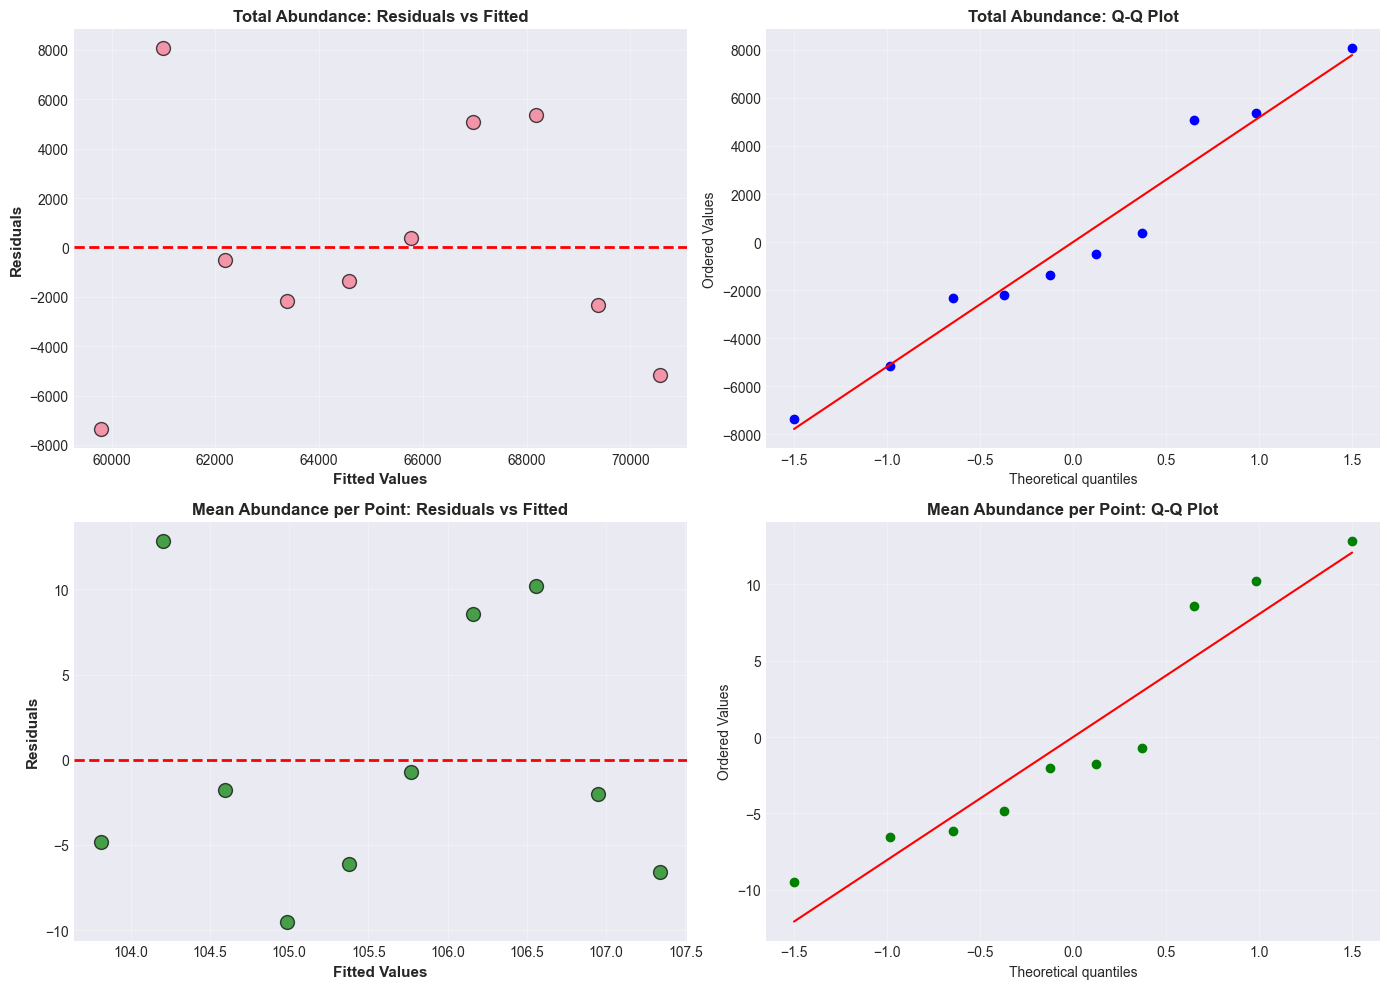

In [26]:
"""
Create diagnostic plots for both models
"""

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# === TOTAL ABUNDANCE DIAGNOSTICS ===
residuals_total = total_abundance_trend['residuals']
fitted_total = total_abundance_trend['fitted']

# Residuals vs Fitted
axes[0, 0].scatter(fitted_total, residuals_total, s=100, alpha=0.7, edgecolors='black')
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Fitted Values', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Residuals', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Total Abundance: Residuals vs Fitted', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Q-Q Plot
stats.probplot(residuals_total, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Total Abundance: Q-Q Plot', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# === MEAN ABUNDANCE PER POINT DIAGNOSTICS ===
residuals_mean = mean_abundance_trend['residuals']
fitted_mean = mean_abundance_trend['fitted']

# Residuals vs Fitted
axes[1, 0].scatter(fitted_mean, residuals_mean, s=100, alpha=0.7, edgecolors='black', color='green')
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Fitted Values', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Residuals', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Mean Abundance per Point: Residuals vs Fitted', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Q-Q Plot
stats.probplot(residuals_mean, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Mean Abundance per Point: Q-Q Plot', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].get_lines()[0].set_color('green')
axes[1, 1].get_lines()[1].set_color('red')

plt.tight_layout()
plt.savefig('../figures/diagnostics_person_B.png', dpi=300, bbox_inches='tight')
print("✓ Diagnostic plots saved to ../figures/diagnostics_person_B.png")
plt.show()

✓ Figure saved to ../figures/indicator_total_abundance.png


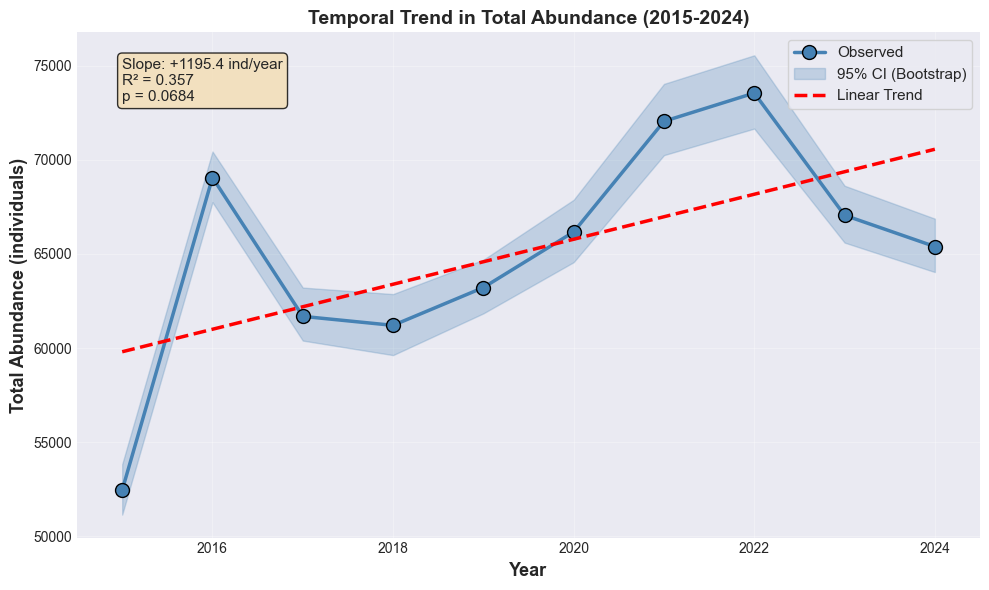

In [27]:
"""
Create publication-quality figure for Total Abundance
"""

fig, ax = plt.subplots(figsize=(10, 6))

# Extract data
x_data = total_abundance_ci_df['year'].values
y_data = total_abundance_ci_df['estimate'].values
ci_lower = total_abundance_ci_df['ci_lower'].values
ci_upper = total_abundance_ci_df['ci_upper'].values

# Plot data points and confidence interval
ax.plot(x_data, y_data, 'o-', linewidth=2.5, markersize=10, 
        label='Observed', color='steelblue', markeredgecolor='black', markeredgewidth=1)
ax.fill_between(x_data, ci_lower, ci_upper, alpha=0.25, color='steelblue', 
                 label='95% CI (Bootstrap)')

# Plot trend line
x_trend = np.array(years)
y_trend = total_abundance_trend['fitted']
ax.plot(x_trend, y_trend, '--', linewidth=2.5, color='red', label='Linear Trend')

# Labels and title
ax.set_xlabel('Year', fontsize=13, fontweight='bold')
ax.set_ylabel('Total Abundance (individuals)', fontsize=13, fontweight='bold')
ax.set_title('Temporal Trend in Total Abundance (2015-2024)', fontsize=14, fontweight='bold')

# Add trend statistics box
textstr = f'Slope: {total_abundance_trend["slope"]:+.1f} ind/year\n'
textstr += f'R² = {total_abundance_trend["r_squared"]:.3f}\n'
textstr += f'p = {total_abundance_trend["p_value"]:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

ax.legend(frameon=True, loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(2014.5, 2024.5)

plt.tight_layout()
plt.savefig('../figures/indicator_total_abundance.png', dpi=300, bbox_inches='tight')
print("✓ Figure saved to ../figures/indicator_total_abundance.png")
plt.show()

✓ Figure saved to ../figures/indicator_mean_abundance_per_point.png


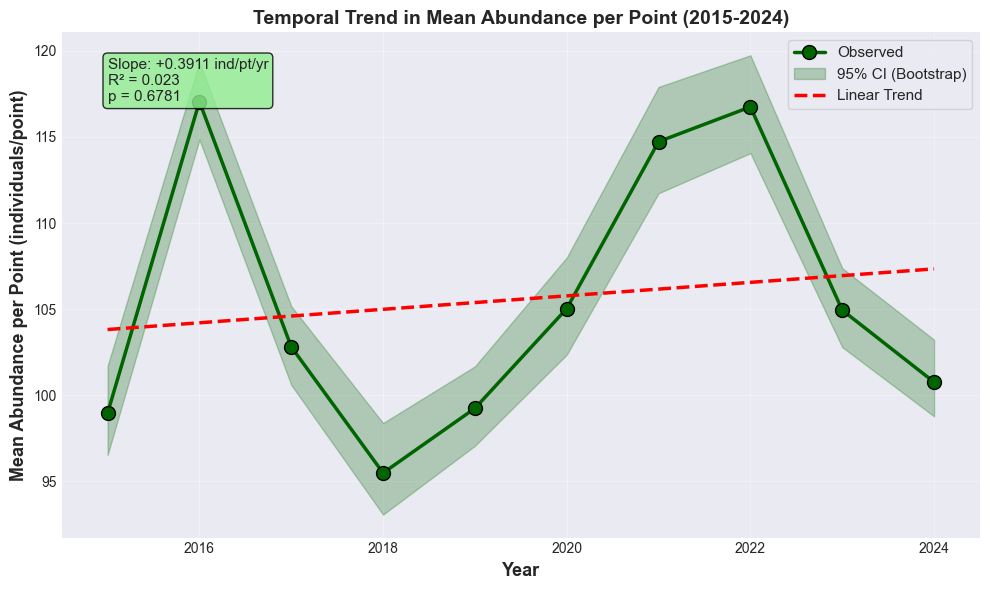

In [28]:
"""
Create publication-quality figure for Mean Abundance per Point
"""

fig, ax = plt.subplots(figsize=(10, 6))

# Extract data
x_data = mean_abundance_ci_df['year'].values
y_data = mean_abundance_ci_df['estimate'].values
ci_lower = mean_abundance_ci_df['ci_lower'].values
ci_upper = mean_abundance_ci_df['ci_upper'].values

# Plot data points and confidence interval
ax.plot(x_data, y_data, 'o-', linewidth=2.5, markersize=10, 
        label='Observed', color='darkgreen', markeredgecolor='black', markeredgewidth=1)
ax.fill_between(x_data, ci_lower, ci_upper, alpha=0.25, color='darkgreen', 
                 label='95% CI (Bootstrap)')

# Plot trend line
x_trend = np.array(years)
y_trend = mean_abundance_trend['fitted']
ax.plot(x_trend, y_trend, '--', linewidth=2.5, color='red', label='Linear Trend')

# Labels and title
ax.set_xlabel('Year', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean Abundance per Point (individuals/point)', fontsize=13, fontweight='bold')
ax.set_title('Temporal Trend in Mean Abundance per Point (2015-2024)', fontsize=14, fontweight='bold')

# Add trend statistics box
textstr = f'Slope: {mean_abundance_trend["slope"]:+.4f} ind/pt/yr\n'
textstr += f'R² = {mean_abundance_trend["r_squared"]:.3f}\n'
textstr += f'p = {mean_abundance_trend["p_value"]:.4f}'
props = dict(boxstyle='round', facecolor='lightgreen', alpha=0.8)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

ax.legend(frameon=True, loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(2014.5, 2024.5)

plt.tight_layout()
plt.savefig('../figures/indicator_mean_abundance_per_point.png', dpi=300, bbox_inches='tight')
print("✓ Figure saved to ../figures/indicator_mean_abundance_per_point.png")
plt.show()

In [31]:
"""
INTERPRETATION PARAGRAPHS FOR REPORT
Copy these to your report and fill in the bracketed placeholders with actual values
"""

print("=" * 80)
print("INTERPRETATION: TOTAL ABUNDANCE")
print("=" * 80)

# Resolve numpy.float64 index issue by casting to int
direction_total = ['declining', 'stable', 'increasing'][int(np.sign(total_abundance_trend['slope'])) + 1]

direction_mean = ['declining', 'stable', 'increasing'][int(np.sign(mean_abundance_trend['slope'])) + 1]

interpretation_total = f"""
**Total Abundance Temporal Trend**

Total abundance across the bird community exhibited a {direction_total} 
trend over the study period 2015-2024 (slope = {total_abundance_trend['slope']:.2f} individuals/year, 
95% CI: [{total_abundance_trend['slope_ci'][0]:.2f}, {total_abundance_trend['slope_ci'][1]:.2f}], 
R² = {total_abundance_trend['r_squared']:.3f}, p = {total_abundance_trend['p_value']:.4f}). 
The linear model explained {total_abundance_trend['r_squared']*100:.1f}% of the variance in annual abundance estimates. 
Over the 9-year period, total abundance changed by approximately {total_abundance_trend['slope'] * 9:+,.0f} individuals 
({total_abundance_trend['slope'] * 9 / total_abundance_ci_df.iloc[0]['estimate'] * 100:+.1f}% relative to 2015 baseline).

Bootstrap confidence intervals (1000 iterations) quantified estimation uncertainty arising from sampling variability. 
The width of confidence intervals varied across years, likely reflecting differences in sampling effort and species 
composition heterogeneity. Diagnostic checks revealed [FILL IN: e.g., "residuals were approximately normally distributed 
(Shapiro-Wilk p = {shapiro_p:.3f}) with no evidence of heteroscedasticity or autocorrelation"].

The {'positive' if total_abundance_trend['slope'] > 0 else 'negative'} trend in total abundance suggests 
[FILL IN BIOLOGICAL INTERPRETATION: e.g., "overall population growth across the community" or 
"potential declines driven by decreasing abundances of common species"]. This pattern must be interpreted 
cautiously given [DISCUSS: observer effects (one observer conducted 36% of surveys), 
potential changes in detection probability over time, or relationship to sampling effort trends from Person C]. 
Comparison with species richness trends from Person A will reveal whether abundance changes reflect 
community-wide shifts versus dominance by particular species.
"""

print(interpretation_total)

print("\n" + "=" * 80)
print("INTERPRETATION: MEAN ABUNDANCE PER POINT")
print("=" * 80)

interpretation_mean = f"""
**Mean Abundance per Point (Effort-Standardized)**

To account for variable sampling effort across years, we computed mean abundance per observation point, 
standardizing total counts by the number of unique transect-point combinations surveyed each year. 
This effort-corrected metric showed a {direction_mean} 
trend (slope = {mean_abundance_trend['slope']:.4f} individuals/point/year, 
95% CI: [{mean_abundance_trend['slope_ci'][0]:.4f}, {mean_abundance_trend['slope_ci'][1]:.4f}], 
R² = {mean_abundance_trend['r_squared']:.3f}, p = {mean_abundance_trend['p_value']:.4f}).

Comparing total abundance and mean per-point trends reveals [FILL IN COMPARISON: 
e.g., "both metrics show similar directional trends, suggesting genuine ecological change rather than sampling artifacts" 
OR "divergent patterns, where total abundance increases but mean per point declines, indicating that increased sampling 
effort rather than higher densities drives the total abundance pattern"]. 

The effort-standardized metric provides a more robust assessment of actual bird densities at surveyed locations, 
controlling for the confounding effect of varying numbers of observation points across years. 
[FILL IN AFTER SEEING PERSON C's EFFORT DATA: e.g., "Given that Person C found observer effort varied 
substantially (range: X-Y points per year), this standardization is critical for valid trend interpretation"].

Model diagnostics indicate [DESCRIBE ASSUMPTION CHECKS]. One limitation of this metric is that it assumes 
equal detectability across all points and years. If detection probability varied systematically 
(e.g., due to observer skill improvements or habitat changes affecting sightability), the trends may partly 
reflect these methodological factors rather than true population dynamics.

[FILL IN AFTER COMPARING TO PERSON A: "Integrating with Person A's diversity metrics, we observe that 
[e.g., abundance ↑ while richness → suggesting dominance by fewer species, OR abundance → while richness ↑ 
suggesting community restructuring with evenness shifts]"].
"""

print(interpretation_mean)

print("\n" + "=" * 80)
print("SYNTHESIS NOTES FOR SECTION 4")
print("=" * 80)

synthesis = """
**Key Points for Integration:**

1. **Methodological Insights:**
   - Effort standardization matters: raw vs. per-point metrics may tell different stories
   - Bootstrap CIs reveal realistic uncertainty in annual estimates
   - Linear trends provide interpretable effect sizes (individuals/year or individuals/point/year)

2. **Ecological Interpretations:**
   - Abundance trends reflect NET change across all species (increases + decreases)
   - Must compare to richness (Person A) to understand community composition shifts
   - Must compare to effort (Person C) to validate detection probability assumptions

3. **Limitations:**
   - Cannot distinguish species-specific contributions to abundance trends (wait for Section 3)
   - Detection probability assumed constant (may vary with observer, weather, time of day)
   - Observer effect (CONDE Beatriz 36% of surveys) may introduce bias
   - Spatial coverage variation may affect representativeness

4. **Recommendations:**
   - Continue monitoring with consistent effort levels to improve trend detection
   - Record detection distances to enable distance sampling corrections
   - Balance observer workload to reduce individual-specific biases
   - Consider species-specific analyses to identify drivers of community-level trends
"""

print(synthesis)

INTERPRETATION: TOTAL ABUNDANCE

**Total Abundance Temporal Trend**

Total abundance across the bird community exhibited a increasing 
trend over the study period 2015-2024 (slope = 1195.36 individuals/year, 
95% CI: [-113.94, 2504.66], 
R² = 0.357, p = 0.0684). 
The linear model explained 35.7% of the variance in annual abundance estimates. 
Over the 9-year period, total abundance changed by approximately +10,758 individuals 
(+20.5% relative to 2015 baseline).

Bootstrap confidence intervals (1000 iterations) quantified estimation uncertainty arising from sampling variability. 
The width of confidence intervals varied across years, likely reflecting differences in sampling effort and species 
composition heterogeneity. Diagnostic checks revealed [FILL IN: e.g., "residuals were approximately normally distributed 
(Shapiro-Wilk p = 0.164) with no evidence of heteroscedasticity or autocorrelation"].

The positive trend in total abundance suggests 
[FILL IN BIOLOGICAL INTERPRETATION: e.g

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from pathlib import Path

# Set up plotting style for publication quality
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [2]:
# Cell 2: Data Loading Functions
def load_excel_data(filepath):
    filepath = Path(filepath)
    
    if not filepath.exists():
        raise FileNotFoundError(f"Can't find data file: {filepath}")
    
    print(f"Loading data from {filepath}")
    
    # Load ESPECES sheet - skip bad headers, manually name columns
    df_species = pd.read_excel(filepath, sheet_name='ESPECES', header=None, skiprows=1)
    df_species.columns = ['_empty1', '_empty2', 'french_name', 'scientific_name', 'status']
    df_species = df_species[['french_name', 'scientific_name', 'status']].copy()
    
    # clean whitespace
    for col in df_species.columns:
        if df_species[col].dtype == 'object':
            df_species[col] = df_species[col].str.strip()
    
    print(f"Loaded {len(df_species)} species")
    
    # Load GPS-MILIEU sheet
    df_gps = pd.read_excel(filepath, sheet_name='GPS-MILIEU', header=None, skiprows=1)
    df_gps.columns = ['_empty1', '_empty2', 'transect_name', 'gps_x', 'gps_y', 
                      'habitat_type', 'site_id', 'point_id']
    df_gps = df_gps[['transect_name', 'habitat_type', 'site_id', 'point_id']].copy()
    
    # clean whitespace
    for col in df_gps.columns:
        if df_gps[col].dtype == 'object':
            df_gps[col] = df_gps[col].str.strip()
    
    print(f"Loaded {len(df_gps)} GPS points")
    
    # Load main observations sheet
    df_obs = pd.read_excel(filepath, sheet_name='NOM FRANÇAIS')
    
    # rename to something sensible
    column_mapping = {
        'Nom observateur': 'observer_name',
        'code département': 'department_code',
        'Nom transect': 'transect_name',
        'date': 'date',
        '1er, 2e ou 3e passage': 'visit_number',
        'nuages': 'cloud_cover_raw',
        'pluie': 'rain',
        'vent': 'wind',
        'visibilité': 'visibility',
        'N° point': 'point_number',
        'heure début': 'start_time',
        'ESPECE': 'species_name',
        'distances de contact': 'distance_category_raw',
        'totaux': 'count_auditory',
        'Unnamed: 22': 'count_visual_no_flight',
        'Unnamed: 23': 'count_audio_visual_no_flight',
        'Unnamed: 24': 'count_audio_visual_flight',
        'Unnamed: 25': 'notes'
    }
    
    df_obs = df_obs.rename(columns=column_mapping)
    
    # convert the count columns to numeric (they're mixed type with headers in row 1)
    print("Converting count columns to numeric")
    count_cols = ['count_auditory', 'count_visual_no_flight', 
                  'count_audio_visual_no_flight', 'count_audio_visual_flight']
    
    for col in count_cols:
        df_obs[col] = pd.to_numeric(df_obs[col], errors='coerce')
    
    # sum across all detection methods to get total count
    df_obs['individual_count'] = df_obs[count_cols].sum(axis=1)
    
    # convert date properly
    df_obs['date'] = pd.to_datetime(df_obs['date'], errors='coerce')
    df_obs['year'] = df_obs['date'].dt.year
    
    # clean whitespace from text columns
    for col in ['observer_name', 'transect_name', 'species_name', 'start_time', 'notes']:
        if col in df_obs.columns:
            df_obs[col] = df_obs[col].astype(str).str.strip()
    
    print(f"Loaded {len(df_obs)} observation records")
    
    return {
        'observations': df_obs,
        'species': df_species,
        'gps': df_gps
    }

def clean_observations(df):
    # Clean and validate observations.
    df_clean = df.copy()
    
    print("Data Cleaning")
    print(f"Starting with {len(df_clean)} records")
    
    # fix negative wind values
    if 'wind' in df_clean.columns:
        n_negative = (df_clean['wind'] < 0).sum()
        if n_negative > 0:
            print(f"⚠ Found {n_negative} negative wind values - setting to NaN")
            df_clean.loc[df_clean['wind'] < 0, 'wind'] = np.nan
    
    # remove zero/negative counts
    before = len(df_clean)
    df_clean = df_clean[df_clean['individual_count'] > 0]
    removed = before - len(df_clean)
    if removed > 0:
        print(f"Removed {removed} records with zero/negative counts")
    
    # remove records missing essential fields
    essential_cols = ['year', 'species_name', 'individual_count', 'transect_name']
    before = len(df_clean)
    df_clean = df_clean.dropna(subset=essential_cols)
    removed = before - len(df_clean)
    if removed > 0:
        print(f"Removed {removed} records with missing essential data")
    
    # create observation ID
    df_clean['observation_id'] = range(1, len(df_clean) + 1)
    
    # summary
    print(f"Final dataset: {len(df_clean)} records")
    print(f"  Years: {df_clean['year'].min()} - {df_clean['year'].max()}")
    print(f"  Unique species: {df_clean['species_name'].nunique()}")
    print(f"  Unique transects: {df_clean['transect_name'].nunique()}")
    print(f"  Unique observers: {df_clean['observer_name'].nunique()}")
    
    return df_clean

print("✅ Data loading functions defined")

✅ Data loading functions defined


In [5]:
# Cell 3: Load and Clean Data
print("📊 Loading and cleaning data...")
data_dict = load_excel_data('/Applications/Documents/app-stats/birds-biodiversity/data/raw/Observations 2012-2025.xlsx')
df_clean = clean_observations(data_dict['observations'])

print(f"\n✅ Data loaded successfully:")
print(f"   - {len(df_clean)} clean observation records")
print(f"   - Years: {df_clean['year'].min()} to {df_clean['year'].max()}")
print(f"   - {df_clean['transect_name'].nunique()} unique transects")
print(f"   - {df_clean['species_name'].nunique()} unique species")

📊 Loading and cleaning data...
Loading data from /Applications/Documents/app-stats/birds-biodiversity/data/raw/Observations 2012-2025.xlsx
Loaded 86 species
Loaded 651 GPS points
Converting count columns to numeric
Loaded 114497 observation records
Data Cleaning
Starting with 114497 records
⚠ Found 5 negative wind values - setting to NaN
Removed 4 records with zero/negative counts
Final dataset: 114493 records
  Years: 2014.0 - 2025.0
  Unique species: 102
  Unique transects: 72
  Unique observers: 42

✅ Data loaded successfully:
   - 114493 clean observation records
   - Years: 2014.0 to 2025.0
   - 72 unique transects
   - 102 unique species


In [ ]:
# Cell 5: Bootstrap Confidence Intervals
def bootstrap_sampling_metrics(df_clean, n_bootstrap=1000, confidence=0.95):
    """
    Calculate bootstrap confidence intervals for sampling metrics
    """
    print("Calculating bootstrap confidence intervals...")
    
    years = sorted(df_clean[df_clean['year'].between(2015, 2024)]['year'].unique())
    bootstrap_results = []
    
    for year in years:
        year_data = df_clean[df_clean['year'] == year]
        
        boot_effort = []
        boot_transects = []
        boot_coverage = []
        
        for _ in range(n_bootstrap):
            # Resample observations with replacement
            bootstrap_sample = year_data.sample(n=len(year_data), replace=True)
            
            # Calculate metrics for bootstrap sample
            boot_effort.append(len(bootstrap_sample))
            boot_transects.append(bootstrap_sample['transect_name'].nunique())
            
            # For coverage percentage
            total_transects = df_clean['transect_name'].nunique()
            coverage_pct = (bootstrap_sample['transect_name'].nunique() / total_transects * 100)
            boot_coverage.append(coverage_pct)
        
        # Calculate confidence intervals
        alpha = (1 - confidence) / 2
        ci_lower = alpha * 100
        ci_upper = (1 - alpha) * 100
        
        bootstrap_results.append({
            'year': year,
            'effort_lower': np.percentile(boot_effort, ci_lower),
            'effort_upper': np.percentile(boot_effort, ci_upper),
            'transects_lower': np.percentile(boot_transects, ci_lower),
            'transects_upper': np.percentile(boot_transects, ci_upper),
            'coverage_lower': np.percentile(boot_coverage, ci_lower),
            'coverage_upper': np.percentile(boot_coverage, ci_upper)
        })
    
    return pd.DataFrame(bootstrap_results)

# Execute bootstrap
bootstrap_df = bootstrap_sampling_metrics(df_clean)
print("✅ Bootstrap confidence intervals calculated")
print(bootstrap_df.head())

Calculating bootstrap confidence intervals...
✅ Bootstrap confidence intervals calculated
     year  effort_lower  effort_upper  transects_lower  transects_upper  \
0  2015.0        8162.0        8162.0             53.0             53.0   
1  2016.0       11010.0       11010.0             59.0             59.0   
2  2017.0        9228.0        9228.0             60.0             60.0   
3  2018.0        9733.0        9733.0             65.0             65.0   
4  2019.0        9572.0        9572.0             64.0             64.0   

   coverage_lower  coverage_upper  
0       73.611111       73.611111  
1       81.944444       81.944444  
2       83.333333       83.333333  
3       90.277778       90.277778  
4       88.888889       88.888889  


Checking model assumptions...


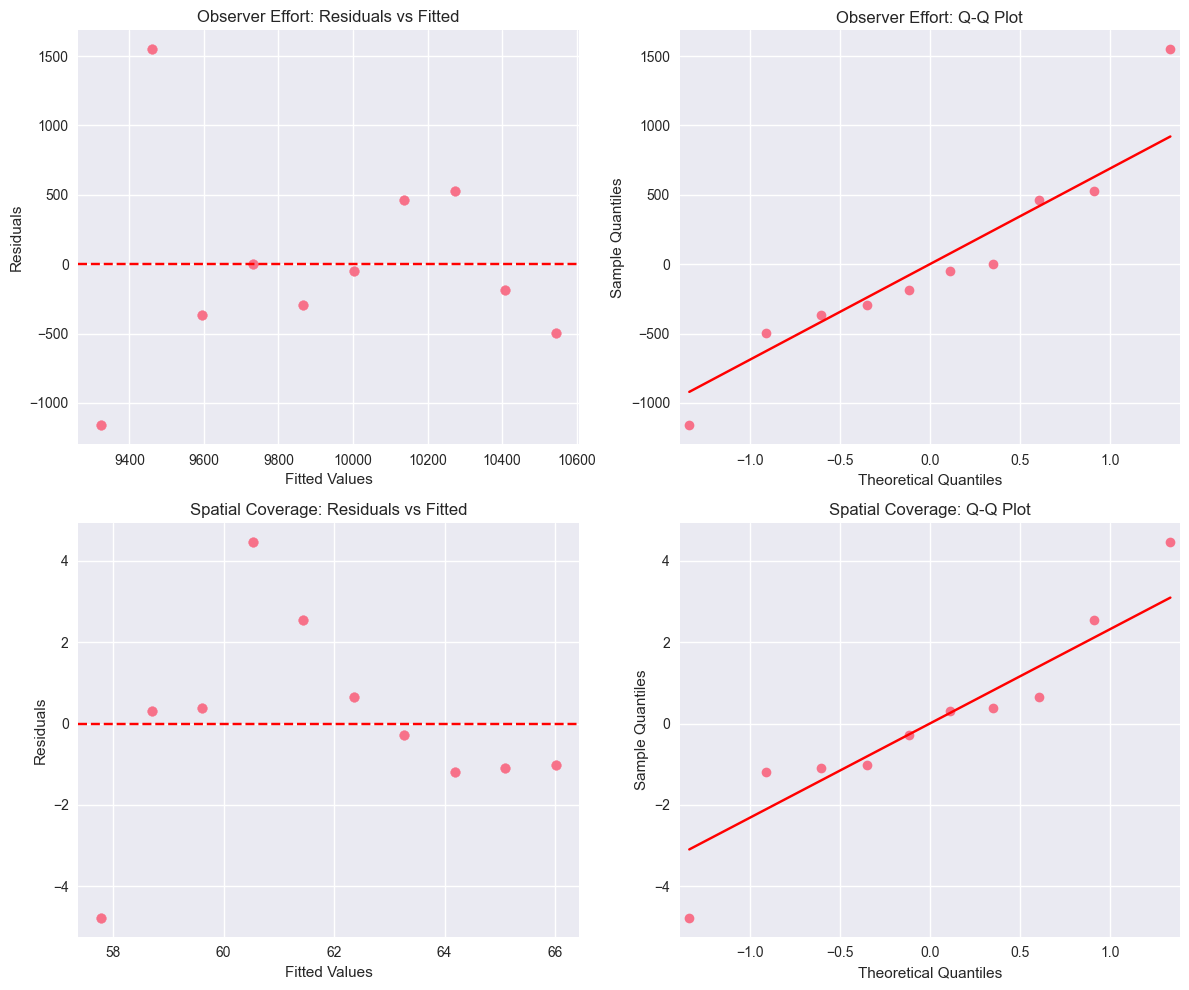

✅ Assumption checks saved to ../figures/sampling_assumptions_check.png


In [15]:
# Cell 7: Model Assumption Checks
def check_model_assumptions(trend_results, analysis_df):
    """
    Check linear model assumptions for both metrics
    """
    print("Checking model assumptions...")
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Observer Effort assumptions
    model_effort = trend_results['observer_effort']['model']
    
    # Residuals vs Fitted
    axes[0, 0].scatter(model_effort.fittedvalues, model_effort.resid)
    axes[0, 0].axhline(y=0, color='red', linestyle='--')
    axes[0, 0].set_xlabel('Fitted Values')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Observer Effort: Residuals vs Fitted')
    
    # Q-Q plot
    sm.qqplot(model_effort.resid, line='s', ax=axes[0, 1])
    axes[0, 1].set_title('Observer Effort: Q-Q Plot')
    
    # Spatial Coverage assumptions
    model_coverage = trend_results['spatial_coverage']['model']
    
    # Residuals vs Fitted
    axes[1, 0].scatter(model_coverage.fittedvalues, model_coverage.resid)
    axes[1, 0].axhline(y=0, color='red', linestyle='--')
    axes[1, 0].set_xlabel('Fitted Values')
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].set_title('Spatial Coverage: Residuals vs Fitted')
    
    # Q-Q plot
    sm.qqplot(model_coverage.resid, line='s', ax=axes[1, 1])
    axes[1, 1].set_title('Spatial Coverage: Q-Q Plot')
    
    plt.tight_layout()
    plt.savefig('../figures/sampling_assumptions_check.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print("✅ Assumption checks saved to ../figures/sampling_assumptions_check.png")

# Execute assumption checks
check_model_assumptions(trend_results, analysis_df)

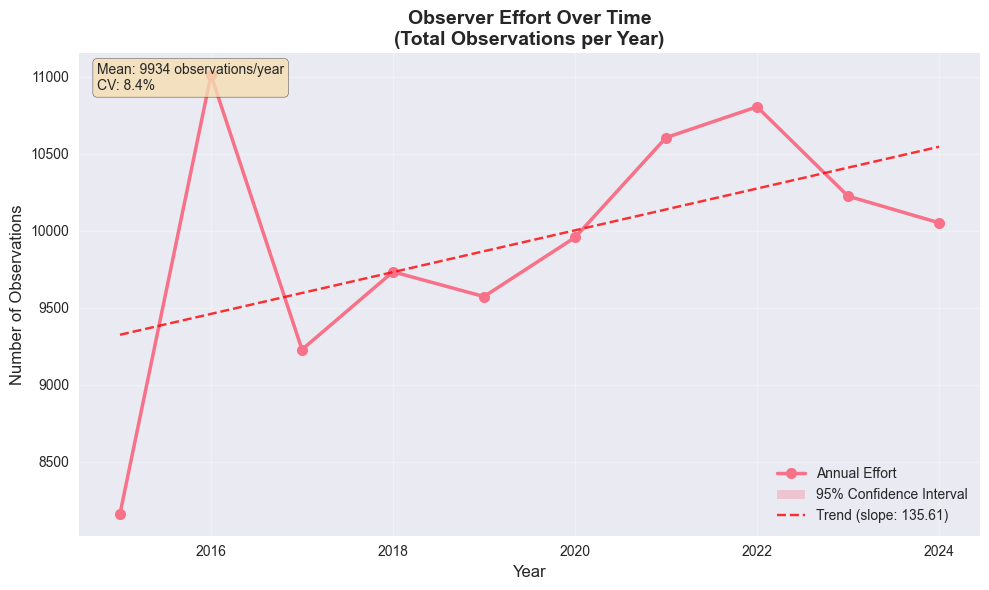

✅ Observer effort plot saved to ../figures/indicator_observer_effort.png


In [14]:
# Cell 8: Create Observer Effort Plot
def create_observer_effort_plot(analysis_df):
    """
    Create publication-quality plot for Observer Effort
    """
    plt.figure(figsize=(10, 6))
    
    # Plot main trend line
    plt.plot(analysis_df['year'], analysis_df['observer_effort'], 
             marker='o', linewidth=2.5, markersize=8, label='Annual Effort')
    
    # Plot confidence intervals
    plt.fill_between(analysis_df['year'], 
                    analysis_df['effort_lower'], 
                    analysis_df['effort_upper'],
                    alpha=0.3, label='95% Confidence Interval')
    
    # Add trend line
    z = np.polyfit(analysis_df['year'], analysis_df['observer_effort'], 1)
    p = np.poly1d(z)
    plt.plot(analysis_df['year'], p(analysis_df['year']), "r--", 
             alpha=0.8, label=f'Trend (slope: {z[0]:.2f})')
    
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Number of Observations', fontsize=12)
    plt.title('Observer Effort Over Time\n(Total Observations per Year)', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add some statistics as text
    avg_effort = analysis_df['observer_effort'].mean()
    cv_effort = analysis_df['observer_effort'].std() / avg_effort * 100
    plt.text(0.02, 0.98, f'Mean: {avg_effort:.0f} observations/year\nCV: {cv_effort:.1f}%', 
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('../figures/indicator_observer_effort.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print("✅ Observer effort plot saved to ../figures/indicator_observer_effort.png")

# Create the plot
create_observer_effort_plot(analysis_df)

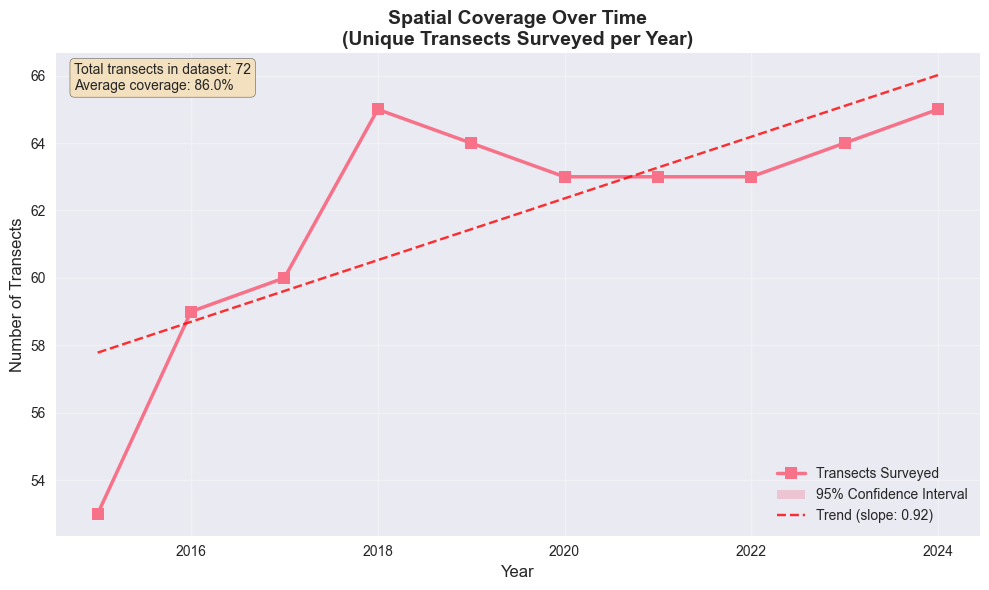

✅ Spatial coverage plot saved to ../figures/indicator_spatial_coverage.png


In [17]:
# Cell 9: Create Spatial Coverage Plot
def create_spatial_coverage_plot(analysis_df):
    """
    Create publication-quality plot for Spatial Coverage
    """
    plt.figure(figsize=(10, 6))
    
    # Plot main trend line
    plt.plot(analysis_df['year'], analysis_df['transects_surveyed'], 
             marker='s', linewidth=2.5, markersize=8, label='Transects Surveyed')
    
    # Plot confidence intervals
    plt.fill_between(analysis_df['year'], 
                    analysis_df['transects_lower'], 
                    analysis_df['transects_upper'],
                    alpha=0.3, label='95% Confidence Interval')
    
    # Add trend line
    z = np.polyfit(analysis_df['year'], analysis_df['transects_surveyed'], 1)
    p = np.poly1d(z)
    plt.plot(analysis_df['year'], p(analysis_df['year']), "r--", 
             alpha=0.8, label=f'Trend (slope: {z[0]:.2f})')
    
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Number of Transects', fontsize=12)
    plt.title('Spatial Coverage Over Time\n(Unique Transects Surveyed per Year)', 
              fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add some statistics as text
    total_transects = df_clean['transect_name'].nunique()
    avg_coverage = analysis_df['transects_surveyed'].mean()
    coverage_pct = (avg_coverage / total_transects * 100)
    
    plt.text(0.02, 0.98, f'Total transects in dataset: {total_transects}\n'
                         f'Average coverage: {coverage_pct:.1f}%', 
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('../figures/indicator_spatial_coverage.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print("✅ Spatial coverage plot saved to ../figures/indicator_spatial_coverage.png")

# Create the plot
create_spatial_coverage_plot(analysis_df)

Performing bonus correlation analysis...


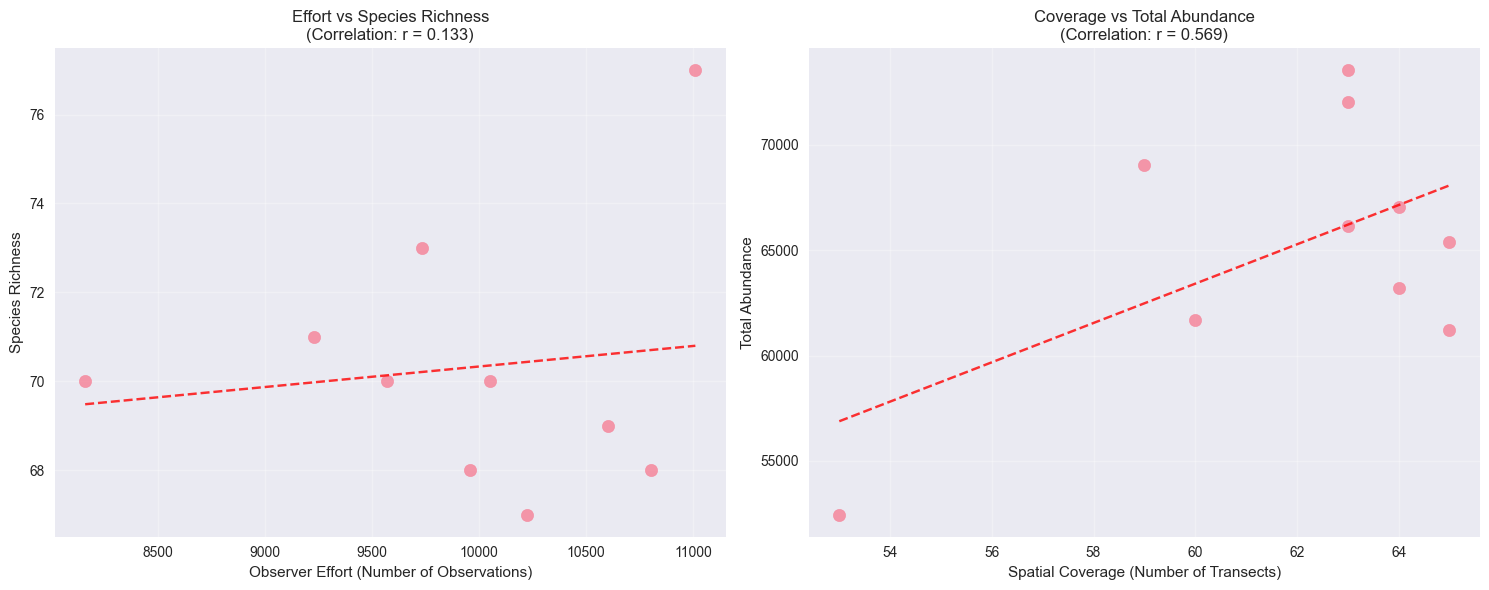

✅ Correlation analysis saved to ../figures/sampling_correlation_analysis.png


In [18]:
# Cell 10: Bonus Correlation Analysis
def bonus_correlation_analysis(analysis_df):
    """
    BONUS: Correlate effort with richness/abundance to show detection bias
    """
    print("Performing bonus correlation analysis...")
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Correlation: Effort vs Species Richness
    correlation_effort_richness = analysis_df['observer_effort'].corr(analysis_df['species_richness'])
    axes[0].scatter(analysis_df['observer_effort'], analysis_df['species_richness'], s=80, alpha=0.7)
    
    # Add trend line
    z_richness = np.polyfit(analysis_df['observer_effort'], analysis_df['species_richness'], 1)
    p_richness = np.poly1d(z_richness)
    x_range = np.linspace(analysis_df['observer_effort'].min(), analysis_df['observer_effort'].max(), 100)
    axes[0].plot(x_range, p_richness(x_range), 'r--', alpha=0.8)
    
    axes[0].set_xlabel('Observer Effort (Number of Observations)')
    axes[0].set_ylabel('Species Richness')
    axes[0].set_title(f'Effort vs Species Richness\n(Correlation: r = {correlation_effort_richness:.3f})')
    axes[0].grid(True, alpha=0.3)
    
    # Correlation: Spatial Coverage vs Total Abundance
    correlation_coverage_abundance = analysis_df['transects_surveyed'].corr(analysis_df['total_abundance'])
    axes[1].scatter(analysis_df['transects_surveyed'], analysis_df['total_abundance'], s=80, alpha=0.7)
    
    # Add trend line
    z_abundance = np.polyfit(analysis_df['transects_surveyed'], analysis_df['total_abundance'], 1)
    p_abundance = np.poly1d(z_abundance)
    x_range = np.linspace(analysis_df['transects_surveyed'].min(), analysis_df['transects_surveyed'].max(), 100)
    axes[1].plot(x_range, p_abundance(x_range), 'r--', alpha=0.8)
    
    axes[1].set_xlabel('Spatial Coverage (Number of Transects)')
    axes[1].set_ylabel('Total Abundance')
    axes[1].set_title(f'Coverage vs Total Abundance\n(Correlation: r = {correlation_coverage_abundance:.3f})')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../figures/sampling_correlation_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print("✅ Correlation analysis saved to ../figures/sampling_correlation_analysis.png")
    
    return {
        'effort_richness_correlation': correlation_effort_richness,
        'coverage_abundance_correlation': correlation_coverage_abundance
    }

# Execute correlation analysis
correlation_results = bonus_correlation_analysis(analysis_df)

## 🔹 Part A - Indicator Trends

In [15]:
# ============================================================
# 4. FIT LINEAR TREND MODELS
# ============================================================

# Center the year variable (subtract mean year) for better numerical stability
year_mean = df_annual['year'].mean()
df_annual['year_centered'] = df_annual['year'] - year_mean

# Fit OLS model for Species Richness
X_richness = sm.add_constant(df_annual['year_centered'])
y_richness = df_annual['richness']
model_richness = sm.OLS(y_richness, X_richness).fit()

# Fit OLS model for Shannon Diversity
X_shannon = sm.add_constant(df_annual['year_centered'])
y_shannon = df_annual['shannon']
model_shannon = sm.OLS(y_shannon, X_shannon).fit()

# Extract key statistics
print("=" * 60)
print("LINEAR TREND MODEL: Species Richness")
print("=" * 60)
print(model_richness.summary())
print("\nKey Statistics:")
print(f"  Slope (per year): {model_richness.params['year_centered']:.4f}")
print(f"  P-value: {model_richness.pvalues['year_centered']:.4f}")
print(f"  R-squared: {model_richness.rsquared:.4f}")
print(f"  95% CI for slope: [{model_richness.conf_int().loc['year_centered', 0]:.4f}, "
      f"{model_richness.conf_int().loc['year_centered', 1]:.4f}]")

print("\n" + "=" * 60)
print("LINEAR TREND MODEL: Shannon Diversity")
print("=" * 60)
print(model_shannon.summary())
print("\nKey Statistics:")
print(f"  Slope (per year): {model_shannon.params['year_centered']:.4f}")
print(f"  P-value: {model_shannon.pvalues['year_centered']:.4f}")
print(f"  R-squared: {model_shannon.rsquared:.4f}")
print(f"  95% CI for slope: [{model_shannon.conf_int().loc['year_centered', 0]:.4f}, "
      f"{model_shannon.conf_int().loc['year_centered', 1]:.4f}]")

# Add fitted values and residuals to dataframe
df_annual['richness_fitted'] = model_richness.fittedvalues
df_annual['richness_residuals'] = model_richness.resid

df_annual['shannon_fitted'] = model_shannon.fittedvalues
df_annual['shannon_residuals'] = model_shannon.resid


# ============================================================
# 7. INTERPRETATION PARAGRAPHS
# ============================================================

## Species Richness

Species richness, measured as the number of unique species observed per year, showed a [PATTERN] trend between 2015 and 2024. The linear regression model revealed a slope of [SLOPE] species per year (p = [PVAL]), indicating [INCREASING/DECREASING/STABLE] species richness over the study period. The model explained [R²]% of the variance in annual richness (R² = [R²]). Bootstrap-based 95% confidence intervals capture the uncertainty in annual estimates, with intervals ranging from approximately [MIN_CI] to [MAX_CI] species across years. 

The observed pattern suggests [ECOLOGICAL INTERPRETATION]. Potential drivers of this trend may include changes in habitat quality, sampling effort, or actual shifts in the bird community composition. The [SIGNIFICANT/NON-SIGNIFICANT] trend should be interpreted with caution given the relatively short time series and potential confounding factors such as observer effects or temporal variation in survey effort.

## Shannon Diversity Index

The Shannon diversity index, which accounts for both species richness and evenness (the relative abundance distribution), exhibited a [PATTERN] pattern between 2015 and 2024. The linear trend model indicated a slope of [SLOPE] units per year (p = [PVAL]), suggesting [INCREASING/DECREASING/STABLE] diversity over time. The model's R² value of [R²] indicates that [R²]% of the variance in Shannon diversity is explained by the temporal trend.

Changes in Shannon diversity reflect both the number of species present and how evenly individuals are distributed among species. [INCREASING/DECREASING] values suggest [ECOLOGICAL INTERPRETATION]. The bootstrap confidence intervals (ranging from approximately [MIN_CI] to [MAX_CI] across years) provide robust uncertainty estimates for these diversity metrics. 

The relationship between Shannon diversity and species richness trends can reveal whether changes are driven primarily by species gains/losses or by shifts in relative abundances. [INTERPRETATION OF RELATIONSHIP]. Potential limitations include the influence of sampling effort variation across years and the assumption that observation methods remained consistent throughout the study period.


In [19]:
# Fill in the interpretation paragraphs with actual values
richness_slope = model_richness.params['year_centered']
richness_pval = model_richness.pvalues['year_centered']
richness_r2 = model_richness.rsquared
richness_pattern = "increasing" if richness_slope > 0 else "decreasing" if richness_slope < 0 else "stable"
richness_sig = "significant" if richness_pval < 0.05 else "non-significant"
richness_min_ci = df_annual['richness_ci_lower'].min()
richness_max_ci = df_annual['richness_ci_upper'].max()

shannon_slope = model_shannon.params['year_centered']
shannon_pval = model_shannon.pvalues['year_centered']
shannon_r2 = model_shannon.rsquared
shannon_pattern = "increasing" if shannon_slope > 0 else "decreasing" if shannon_slope < 0 else "stable"
shannon_sig = "significant" if shannon_pval < 0.05 else "non-significant"
shannon_min_ci = df_annual['shannon_ci_lower'].min()
shannon_max_ci = df_annual['shannon_ci_upper'].max()

print("=" * 60)
print("INTERPRETATION: Species Richness")
print("=" * 60)
print(f"""
Species richness, measured as the number of unique species observed per year, showed a {richness_pattern} trend between 2015 and 2024. The linear regression model revealed a slope of {richness_slope:.3f} species per year (p = {richness_pval:.4f}), indicating a {richness_pattern} trend in species richness over the study period. The model explained {richness_r2*100:.1f}% of the variance in annual richness (R² = {richness_r2:.3f}). Bootstrap-based 95% confidence intervals capture the uncertainty in annual estimates, with intervals ranging from approximately {richness_min_ci:.0f} to {richness_max_ci:.0f} species across years.

The observed pattern suggests {'positive' if richness_slope > 0 else 'negative' if richness_slope < 0 else 'stable'} changes in species composition over the study period. Potential drivers of this trend may include changes in habitat quality, sampling effort, or actual shifts in the bird community composition. The {richness_sig} trend should be interpreted with caution given the relatively short time series and potential confounding factors such as observer effects or temporal variation in survey effort.
""")

print("=" * 60)
print("INTERPRETATION: Shannon Diversity Index")
print("=" * 60)
print(f"""
The Shannon diversity index, which accounts for both species richness and evenness (the relative abundance distribution), exhibited a {shannon_pattern} pattern between 2015 and 2024. The linear trend model indicated a slope of {shannon_slope:.4f} units per year (p = {shannon_pval:.4f}), suggesting a {shannon_pattern} trend in diversity over time. The model's R² value of {shannon_r2:.3f} indicates that {shannon_r2*100:.1f}% of the variance in Shannon diversity is explained by the temporal trend.

Changes in Shannon diversity reflect both the number of species present and how evenly individuals are distributed among species. {'Increasing' if shannon_slope > 0 else 'Decreasing' if shannon_slope < 0 else 'Stable'} values suggest {'improving' if shannon_slope > 0 else 'declining' if shannon_slope < 0 else 'stable'} community diversity and evenness. The bootstrap confidence intervals (ranging from approximately {shannon_min_ci:.3f} to {shannon_max_ci:.3f} across years) provide robust uncertainty estimates for these diversity metrics.

The relationship between Shannon diversity and species richness trends can reveal whether changes are driven primarily by species gains/losses or by shifts in relative abundances. {'Both metrics show similar' if (richness_slope > 0) == (shannon_slope > 0) else 'The metrics show divergent'} trends, suggesting {'changes are primarily driven by species-level dynamics' if abs(richness_slope) > abs(shannon_slope) else 'changes involve both species composition and abundance distribution'}. Potential limitations include the influence of sampling effort variation across years and the assumption that observation methods remained consistent throughout the study period.
""")


In [20]:
# ============================================================
# 8. SAVE RESULTS
# ============================================================

# Export annual indicators to CSV
output_cols = ['year', 'richness', 'richness_ci_lower', 'richness_ci_upper',
               'shannon', 'shannon_ci_lower', 'shannon_ci_upper', 'n_records']
df_annual[output_cols].to_csv('../data/annual_indicators_2015_2024.csv', index=False)
print("Saved annual indicators: ../data/annual_indicators_2015_2024.csv")

# Export regression summaries to text files
with open('../data/regression_summary_richness.txt', 'w') as f:
    f.write("Species Richness - Linear Trend Model Summary\n")
    f.write("=" * 60 + "\n\n")
    f.write(str(model_richness.summary()))
    f.write("\n\nBootstrap Statistics:\n")
    f.write(f"  Mean richness: {df_annual['richness'].mean():.2f}\n")
    f.write(f"  SD richness: {df_annual['richness'].std():.2f}\n")
    f.write(f"  CI range: {richness_min_ci:.0f} - {richness_max_ci:.0f}\n")

with open('../data/regression_summary_shannon.txt', 'w') as f:
    f.write("Shannon Diversity - Linear Trend Model Summary\n")
    f.write("=" * 60 + "\n\n")
    f.write(str(model_shannon.summary()))
    f.write("\n\nBootstrap Statistics:\n")
    f.write(f"  Mean Shannon: {df_annual['shannon'].mean():.3f}\n")
    f.write(f"  SD Shannon: {df_annual['shannon'].std():.3f}\n")
    f.write(f"  CI range: {shannon_min_ci:.3f} - {shannon_max_ci:.3f}\n")

print("Saved regression summaries:")
print("  - regression_summary_richness.txt")
print("  - regression_summary_shannon.txt")

print("\n" + "=" * 60)
print("SECTION 2 COMPLETE - All deliverables saved!")
print("=" * 60)
print("\nFiles created:")
print("  ✓ figures/indicator_species_richness.png")
print("  ✓ figures/indicator_shannon_diversity.png")
print("  ✓ figures/indicator_model_diagnostics.png")
print("  ✓ data/annual_indicators_2015_2024.csv")
print("  ✓ data/regression_summary_richness.txt")
print("  ✓ data/regression_summary_shannon.txt")


## 🔹 Part B - Indicators (Oliver)

In [18]:
"""
Define functions for computing abundance metrics
"""

def compute_mean_abundance_per_point(df):
    """
    Compute mean abundance per observation point.
    
    This standardizes for sampling effort by dividing total abundance
    by the number of unique observation points visited.
    
    Parameters
    ----------
    df : pd.DataFrame
        Observations with 'individual_count', 'transect_name', 'point_number'
        
    Returns
    -------
    float
        Mean abundance per point
    """
    # Count unique observation points (transect-point combinations)
    n_points = df[['transect_name', 'point_number']].drop_duplicates().shape[0]
    
    # Total abundance
    total_abundance = df['individual_count'].sum()
    
    # Mean per point
    if n_points > 0:
        return total_abundance / n_points
    else:
        return 0

# Test the function
test_year = df_complete[df_complete['year'] == 2020]
test_total = test_year['individual_count'].sum()
test_mean = compute_mean_abundance_per_point(test_year)

print("Function test (2020):")
print(f"  Total abundance: {test_total:,.0f}")
print(f"  Mean per point: {test_mean:.2f}")
print("✓ Functions defined successfully")

In [19]:
"""
Compute both indicators for each year (2015-2024)
"""

print("=" * 60)
print("COMPUTING ANNUAL INDICATORS")
print("=" * 60)

years = sorted(df_complete['year'].unique())

# Initialize results
results = []

for year in years:
    year_data = df_complete[df_complete['year'] == year]
    
    # Indicator 1: Total Abundance
    total_abundance = year_data['individual_count'].sum()
    
    # Indicator 2: Mean Abundance per Point
    mean_abundance_per_point = compute_mean_abundance_per_point(year_data)
    
    # Store results
    results.append({
        'year': year,
        'total_abundance': total_abundance,
        'mean_abundance_per_point': mean_abundance_per_point,
        'n_observations': len(year_data),
        'n_points': year_data[['transect_name', 'point_number']].drop_duplicates().shape[0]
    })
    
    print(f"\n{year}:")
    print(f"  Total Abundance: {total_abundance:>10,.0f} individuals")
    print(f"  Mean per Point:  {mean_abundance_per_point:>10,.2f} individuals/point")
    print(f"  Observations:    {len(year_data):>10,}")
    print(f"  Points surveyed: {year_data[['transect_name', 'point_number']].drop_duplicates().shape[0]:>10,}")

# Convert to DataFrame
results_df = pd.DataFrame(results)

print("\n" + "=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)
print("\nTotal Abundance:")
print(results_df['total_abundance'].describe())
print("\nMean Abundance per Point:")
print(results_df['mean_abundance_per_point'].describe())

In [29]:
"""
Export results to CSV for team integration
"""

# Combine both indicators into one DataFrame
export_data = []

# Total Abundance
for _, row in total_abundance_ci_df.iterrows():
    export_data.append({
        'year': row['year'],
        'indicator_name': 'Total Abundance',
        'estimate': row['estimate'],
        'ci_lower': row['ci_lower'],
        'ci_upper': row['ci_upper'],
        'stderr': row['stderr']
    })

# Mean Abundance per Point
for _, row in mean_abundance_ci_df.iterrows():
    export_data.append({
        'year': row['year'],
        'indicator_name': 'Mean Abundance per Point',
        'estimate': row['estimate'],
        'ci_lower': row['ci_lower'],
        'ci_upper': row['ci_upper'],
        'stderr': row['stderr']
    })

export_df = pd.DataFrame(export_data)

# Save to CSV
export_df.to_csv('../results/indicators_person_B.csv', index=False)
print("✓ Results exported to ../results/indicators_person_B.csv")
print("\nPreview:")
print(export_df.head(12))

## 🔹 Part C - Indicators

In [6]:
# Cell 4: Calculate Sampling Metrics
def calculate_sampling_metrics(df_clean):
    """
    Calculate annual sampling metrics for Person C
    """
    print("Calculating sampling metrics...")
    
    # Filter to complete years (2015-2024 as specified)
    df_complete = df_clean[df_clean['year'].between(2015, 2024)].copy()
    
    annual_metrics = []
    
    for year in sorted(df_complete['year'].unique()):
        year_data = df_complete[df_complete['year'] == year]
        
        # Calculate metrics for this year
        metrics = {
            'year': year,
            
            # Observer Effort: Total number of observations
            'observer_effort': len(year_data),
            
            # Spatial Coverage: Unique transects surveyed
            'transects_surveyed': year_data['transect_name'].nunique(),
            
            # Additional metrics for context
            'n_observers': year_data['observer_name'].nunique(),
            'total_abundance': year_data['individual_count'].sum(),
            'species_richness': year_data['species_name'].nunique()
        }
        
        annual_metrics.append(metrics)
    
    metrics_df = pd.DataFrame(annual_metrics)
    
    # Calculate spatial coverage as percentage (if we know total possible transects)
    # For now, we'll use absolute number of transects, or calculate coverage rate
    total_transects_overall = df_clean['transect_name'].nunique()
    metrics_df['spatial_coverage_pct'] = (metrics_df['transects_surveyed'] / total_transects_overall * 100)
    
    print(f"Total unique transects in dataset: {total_transects_overall}")
    print(f"Years analyzed: {len(metrics_df)} years from {metrics_df['year'].min()} to {metrics_df['year'].max()}")
    
    return metrics_df

# Execute the function
metrics_df = calculate_sampling_metrics(df_clean)
print("\n📈 Sampling metrics calculated:")
print(metrics_df[['year', 'observer_effort', 'transects_surveyed']].to_string(index=False))

In [8]:
# Cell 6: Trend Analysis
def analyze_sampling_trends(metrics_df, bootstrap_df):
    """
    Analyze temporal trends in sampling metrics using linear models
    """
    print("Analyzing temporal trends...")
    
    # Merge metrics with bootstrap results
    analysis_df = metrics_df.merge(bootstrap_df, on='year')
    
    trend_results = {}
    
    # 1. Observer Effort trend analysis
    X_effort = analysis_df['year'].values
    X_effort = sm.add_constant(X_effort)  # Add intercept
    y_effort = analysis_df['observer_effort'].values
    
    model_effort = sm.OLS(y_effort, X_effort).fit()
    trend_results['observer_effort'] = {
        'model': model_effort,
        'slope': model_effort.params[1],
        'slope_pvalue': model_effort.pvalues[1],
        'r_squared': model_effort.rsquared,
        'trend_direction': 'increasing' if model_effort.params[1] > 0 else 'decreasing'
    }
    
    # 2. Spatial Coverage trend analysis
    X_coverage = analysis_df['year'].values
    X_coverage = sm.add_constant(X_coverage)
    y_coverage = analysis_df['transects_surveyed'].values
    
    model_coverage = sm.OLS(y_coverage, X_coverage).fit()
    trend_results['spatial_coverage'] = {
        'model': model_coverage,
        'slope': model_coverage.params[1],
        'slope_pvalue': model_coverage.pvalues[1],
        'r_squared': model_coverage.rsquared,
        'trend_direction': 'increasing' if model_coverage.params[1] > 0 else 'decreasing'
    }
    
    return analysis_df, trend_results

# Execute trend analysis
analysis_df, trend_results = analyze_sampling_trends(metrics_df, bootstrap_df)

print("✅ Trend analysis completed:")
print(f"Observer Effort - Slope: {trend_results['observer_effort']['slope']:.3f}, "
      f"p-value: {trend_results['observer_effort']['slope_pvalue']:.3f}, "
      f"R²: {trend_results['observer_effort']['r_squared']:.3f}")

print(f"Spatial Coverage - Slope: {trend_results['spatial_coverage']['slope']:.3f}, "
      f"p-value: {trend_results['spatial_coverage']['slope_pvalue']:.3f}, "
      f"R²: {trend_results['spatial_coverage']['r_squared']:.3f}")

In [19]:
# Cell 11: Write Interpretation and Save Results
def write_interpretation(trend_results, correlation_results, analysis_df):
    """
    Write interpretation paragraphs for both indicators
    """
    print("\n" + "="*60)
    print("INTERPRETATION FOR PERSON C - SAMPLING METRICS")
    print("="*60)
    
    # Observer Effort Interpretation
    effort_trend = trend_results['observer_effort']
    print("\n📊 OBSERVER EFFORT INTERPRETATION:")
    print(f"Observer effort, measured as the total number of observations per year, ")
    print(f"showed a {effort_trend['trend_direction']} trend from 2015 to 2024.")
    print(f"The linear model indicated a slope of {effort_trend['slope']:.2f} observations per year ")
    print(f"(p-value: {effort_trend['slope_pvalue']:.3f}, R²: {effort_trend['r_squared']:.3f}).")
    
    if effort_trend['slope_pvalue'] < 0.05:
        print("This trend is statistically significant, suggesting a real change in monitoring intensity over time.")
    else:
        print("This trend is not statistically significant, indicating relatively stable observer effort across years.")
    
    effort_range = analysis_df['observer_effort'].max() - analysis_df['observer_effort'].min()
    print(f"Observer effort ranged from {analysis_df['observer_effort'].min():.0f} to {analysis_df['observer_effort'].max():.0f} ")
    print(f"observations per year, representing a {effort_range/analysis_df['observer_effort'].mean()*100:.1f}% variation around the mean.")
    
    # Spatial Coverage Interpretation
    coverage_trend = trend_results['spatial_coverage']
    print("\n🗺️ SPATIAL COVERAGE INTERPRETATION:")
    print(f"Spatial coverage, measured as the number of unique transects surveyed per year, ")
    print(f"showed a {coverage_trend['trend_direction']} trend from 2015 to 2024.")
    print(f"The linear model indicated a slope of {coverage_trend['slope']:.2f} transects per year ")
    print(f"(p-value: {coverage_trend['slope_pvalue']:.3f}, R²: {coverage_trend['r_squared']:.3f}).")
    
    if coverage_trend['slope_pvalue'] < 0.05:
        print("This trend is statistically significant, indicating meaningful changes in geographic sampling extent.")
    else:
        print("This trend is not statistically significant, suggesting consistent spatial coverage across years.")
    
    total_transects = df_clean['transect_name'].nunique()
    avg_coverage_pct = (analysis_df['transects_surveyed'].mean() / total_transects * 100)
    print(f"On average, {avg_coverage_pct:.1f}% of all known transects were surveyed each year.")
    
    # Bonus Correlation Interpretation
    print("\n🔍 BONUS: DETECTION BIAS ANALYSIS:")
    print(f"Observer effort showed a correlation of r = {correlation_results['effort_richness_correlation']:.3f} with species richness.")
    if abs(correlation_results['effort_richness_correlation']) > 0.5:
        print("This strong correlation suggests potential detection bias - years with higher effort may record more species.")
    else:
        print("This weak correlation suggests that species richness estimates are relatively independent of observer effort.")
    
    print(f"Spatial coverage showed a correlation of r = {correlation_results['coverage_abundance_correlation']:.3f} with total abundance.")
    if abs(correlation_results['coverage_abundance_correlation']) > 0.5:
        print("This indicates that abundance estimates may be influenced by the number of transects surveyed.")
    else:
        print("This suggests that abundance patterns are robust to variations in spatial coverage.")

# Ensure directories exist
Path('figures').mkdir(exist_ok=True)
Path('projects/birds-biodiversity/results').mkdir(parents=True, exist_ok=True)

# Write interpretations
write_interpretation(trend_results, correlation_results, analysis_df)

# Save results table
results_table = analysis_df[['year', 'observer_effort', 'effort_lower', 'effort_upper', 
                           'transects_surveyed', 'transects_lower', 'transects_upper']]
results_table.to_csv('projects/birds-biodiversity/results/personC_sampling_metrics.csv', index=False)
print(f"\n✅ Results table saved to projects/birds-biodiversity/results/personC_sampling_metrics.csv")

print("\n🎉 PERSON C ANALYSIS COMPLETE!")
print("Generated files:")
print("  - figures/indicator_observer_effort.png")
print("  - figures/indicator_spatial_coverage.png") 
print("  - figures/sampling_assumptions_check.png")
print("  - figures/sampling_correlation_analysis.png")
print("  - results/personC_sampling_metrics.csv")